# **Comparison of Machine Learning Prediction Models**

Reference:
- https://www.kaggle.com/code/sudhirnl7/linear-regression-tutorial
- https://github.com/ashishpatel26/Amazing-Feature-Engineering/blob/master/A%20Short%20Guide%20for%20Feature%20Engineering%20and%20Feature%20Selection.md
- https://github.com/Avinash793/regression-analysis-examples/blob/master/Exchange%20Rate%20Regimes%20Using%20%20Multiple%20Linear%20Regression%20Model.ipynb
- https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/07_linear_models/03_preparing_the_model_data.ipynb
- https://github.com/leihao1/Comparison-of-Machine-Learning-Prediction-Models/blob/master/regression/regression.ipynb
- https://github.com/VenkyAdi/Customer-Purchase-Behavior-Analysis-using-Descriptive-Statistics/blob/main/Applied_Statistics_Project.ipynb


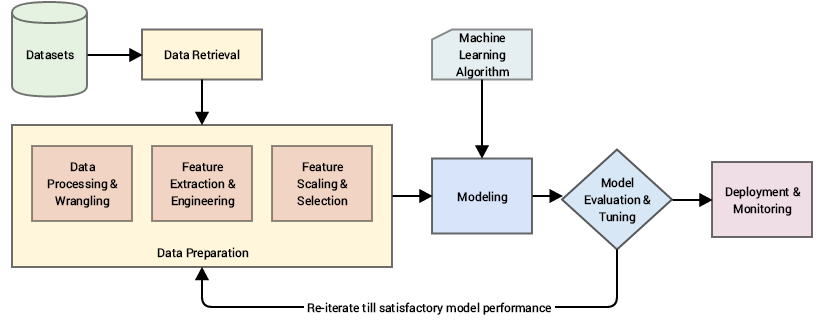

# Load Libary

In [230]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import norm
import matplotlib.pyplot as plt
import itertools
import random

# Load Data

In [39]:
# Load Data
def load_stock_data(file_path, start_date, end_date):
    """Load stock data from SQLite database using StockFeaturePipeline."""
    pipeline = StockFeaturePipeline(file_path)
    data = pipeline.run_pipeline(start_date, end_date)
    return data

In [40]:
file_path = '/Users/kevinleungch421/Documents/GitHub/Database/DataBase/stock_price.sqlite'
raw_data = load_stock_data(file_path, '2017-01-01', '2021-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2017-01-31 to 2020-12-31
Freq: M
Columns: 189 entries, open to Future_Log_Returns
dtypes: float64(185), int64(2), object(1), period[M](1)
memory usage: 71.2+ KB
None


# Handle Missing Values

In [41]:
# Handle Missing Values
def handle_missing_values(df):
    """Remove rows with missing target and fill NaNs in numerical columns with means."""
    df = df.dropna(subset=['Future_Log_Returns'])  # Drop rows where target is NaN
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Future_Log_Returns', errors='ignore')
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].mean())
    return df

In [44]:
# Run
clean_data = handle_missing_values(raw_data)

In [45]:
# B4
print("Missing Values before Cleaning:")
print(raw_data.isnull().sum().sort_values(ascending=False))

# AF
print("Missing Values After Cleaning:")
print(clean_data.isnull().sum().sort_values(ascending=False))

Missing Values before Cleaning:
Future_Log_Returns    1
^VXN_lag1             0
^TNX_lag63            0
DX-Y.NYB_lag1         0
DX-Y.NYB_lag10        0
                     ..
Typical_Price         0
VWAP_20               0
Unemployment_error    0
CPI_error             0
^VIX_lag1             0
Length: 189, dtype: int64
Missing Values After Cleaning:
open                  0
^VXN_lag1             0
^TNX_lag63            0
DX-Y.NYB_lag1         0
DX-Y.NYB_lag10        0
                     ..
Typical_Price         0
VWAP_20               0
Unemployment_error    0
CPI_error             0
Future_Log_Returns    0
Length: 189, dtype: int64


# Detect and Handle Outliers

In [46]:
# Detect and Handle Outliers
def z_score_mark_outliers(df, threshold=3, handle_outliers=True):
    """Detect and cap outliers using z-scores."""
    df = df.copy()
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    if not numerical_cols.size:
        print("No numerical columns found.")
        return df
    
    total_outliers = 0
    for col in numerical_cols:
        mean = df[col].mean()
        std = df[col].std()
        if std == 0:
            continue
        z_scores = np.abs((df[col] - mean) / std)
        col_outliers = z_scores > threshold
        total_outliers += col_outliers.sum()
        if handle_outliers:
            lower_bound = mean - threshold * std
            upper_bound = mean + threshold * std
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    prob = 100 * 2 * norm.sf(threshold)
    print(f"z-score threshold {threshold}: {prob:.2f}% probability, {total_outliers} outliers handled.")
    return df

In [47]:
# Run
outlier_data = z_score_mark_outliers(clean_data)

z-score threshold 3: 0.27% probability, 65 outliers handled.


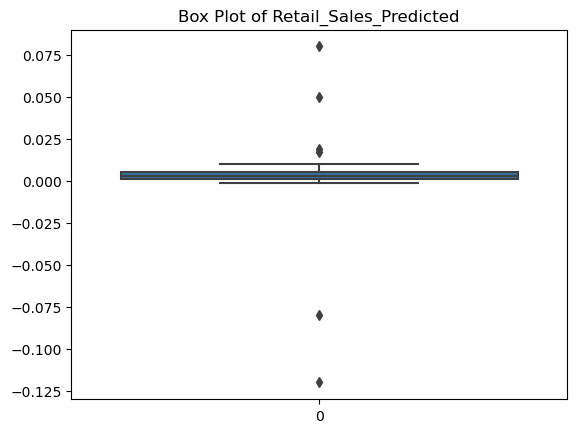

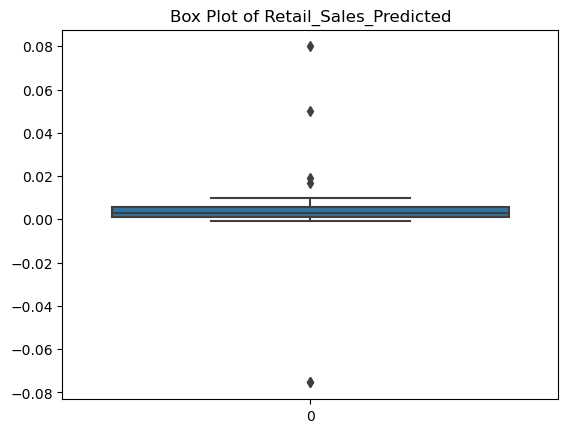

In [55]:
# Box Plot compair 
def box_plot(df, column):
    sns.boxplot(df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

column = 'Retail_Sales_Predicted'

# B4
box_plot(clean_data, column)

# AF
box_plot(outlier_data, column)

# Apply Log Transformation

In [53]:
def log_transform_df(df):
    """Apply log transformation to numerical columns, handling non-positive values."""
    df = df.copy()
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    if not numerical_cols.size:
        print("No numerical columns found.")
        return df
    
    for col in numerical_cols:
        min_value = df[col].min()
        constant = abs(min_value) + 1 if min_value <= 0 else 1
        df[col] = np.log(df[col] + constant)
    return df

In [54]:
transformed_data = log_transform_df(outlier_data)

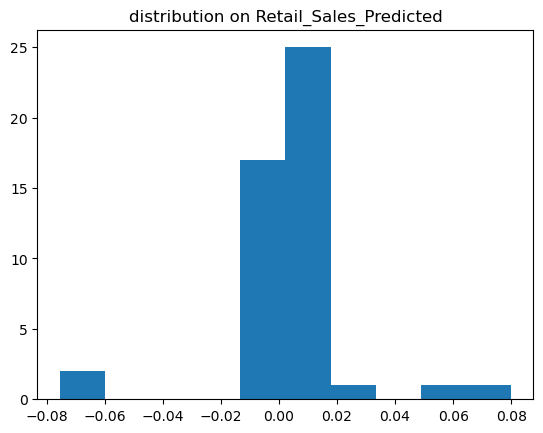

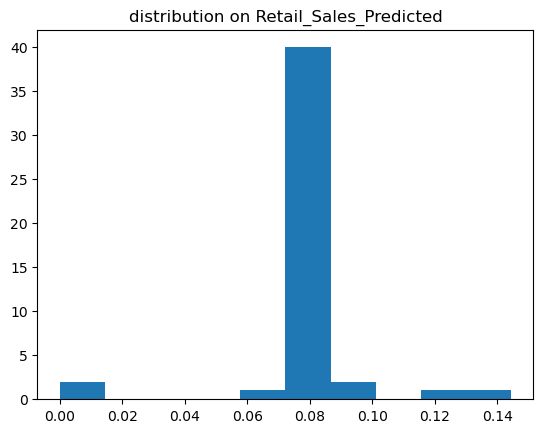

In [57]:
def bar_plot(df, column):
    plt.hist(df[column])
    plt.title(f'distribution on {column}')
    plt.show()

column = 'Retail_Sales_Predicted'

# B4
bar_plot(outlier_data, column)

# AF
bar_plot(transformed_data, column)

# Scale Data

In [58]:
# Scale Data
def min_max_scaler_all_numerical(df, feature_range=(0, 1)):
    """Scale all numerical columns using Min-Max scaling."""
    df = df.copy()
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    if not numerical_cols.size:
        print("No numerical columns found.")
        return df
    
    for col in numerical_cols:
        if df[col].isna().all() or df[col].nunique() <= 1:
            print(f"Skipping {col}: NaN or constant.")
            continue
        col_min, col_max = df[col].min(), df[col].max()
        if col_max == col_min:
            continue
        df[col] = (df[col] - col_min) / (col_max - col_min) * (feature_range[1] - feature_range[0]) + feature_range[0]
    return df

In [59]:
# Run
scaled_df = min_max_scaler_all_numerical(transformed_data)

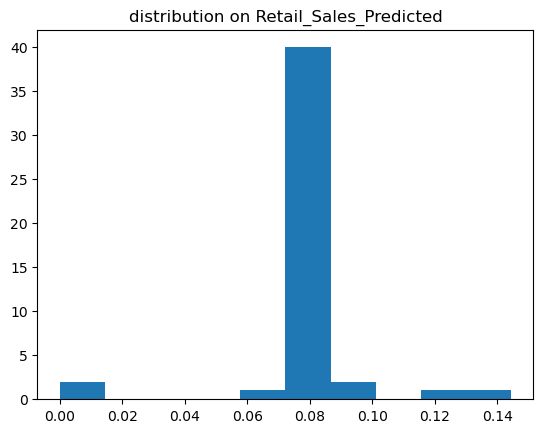

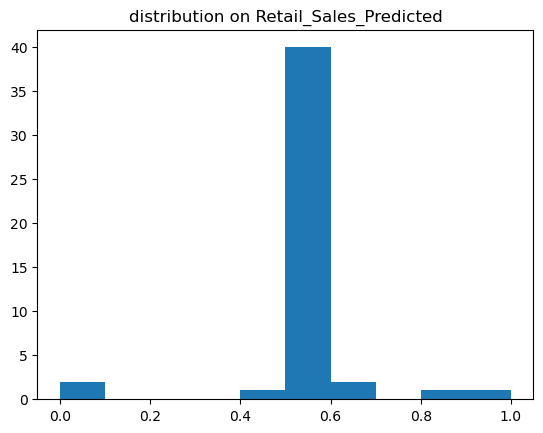

In [60]:
column = 'Retail_Sales_Predicted'

# B4
bar_plot(transformed_data, column)

# AF
bar_plot(scaled_df, column)

# Visualization

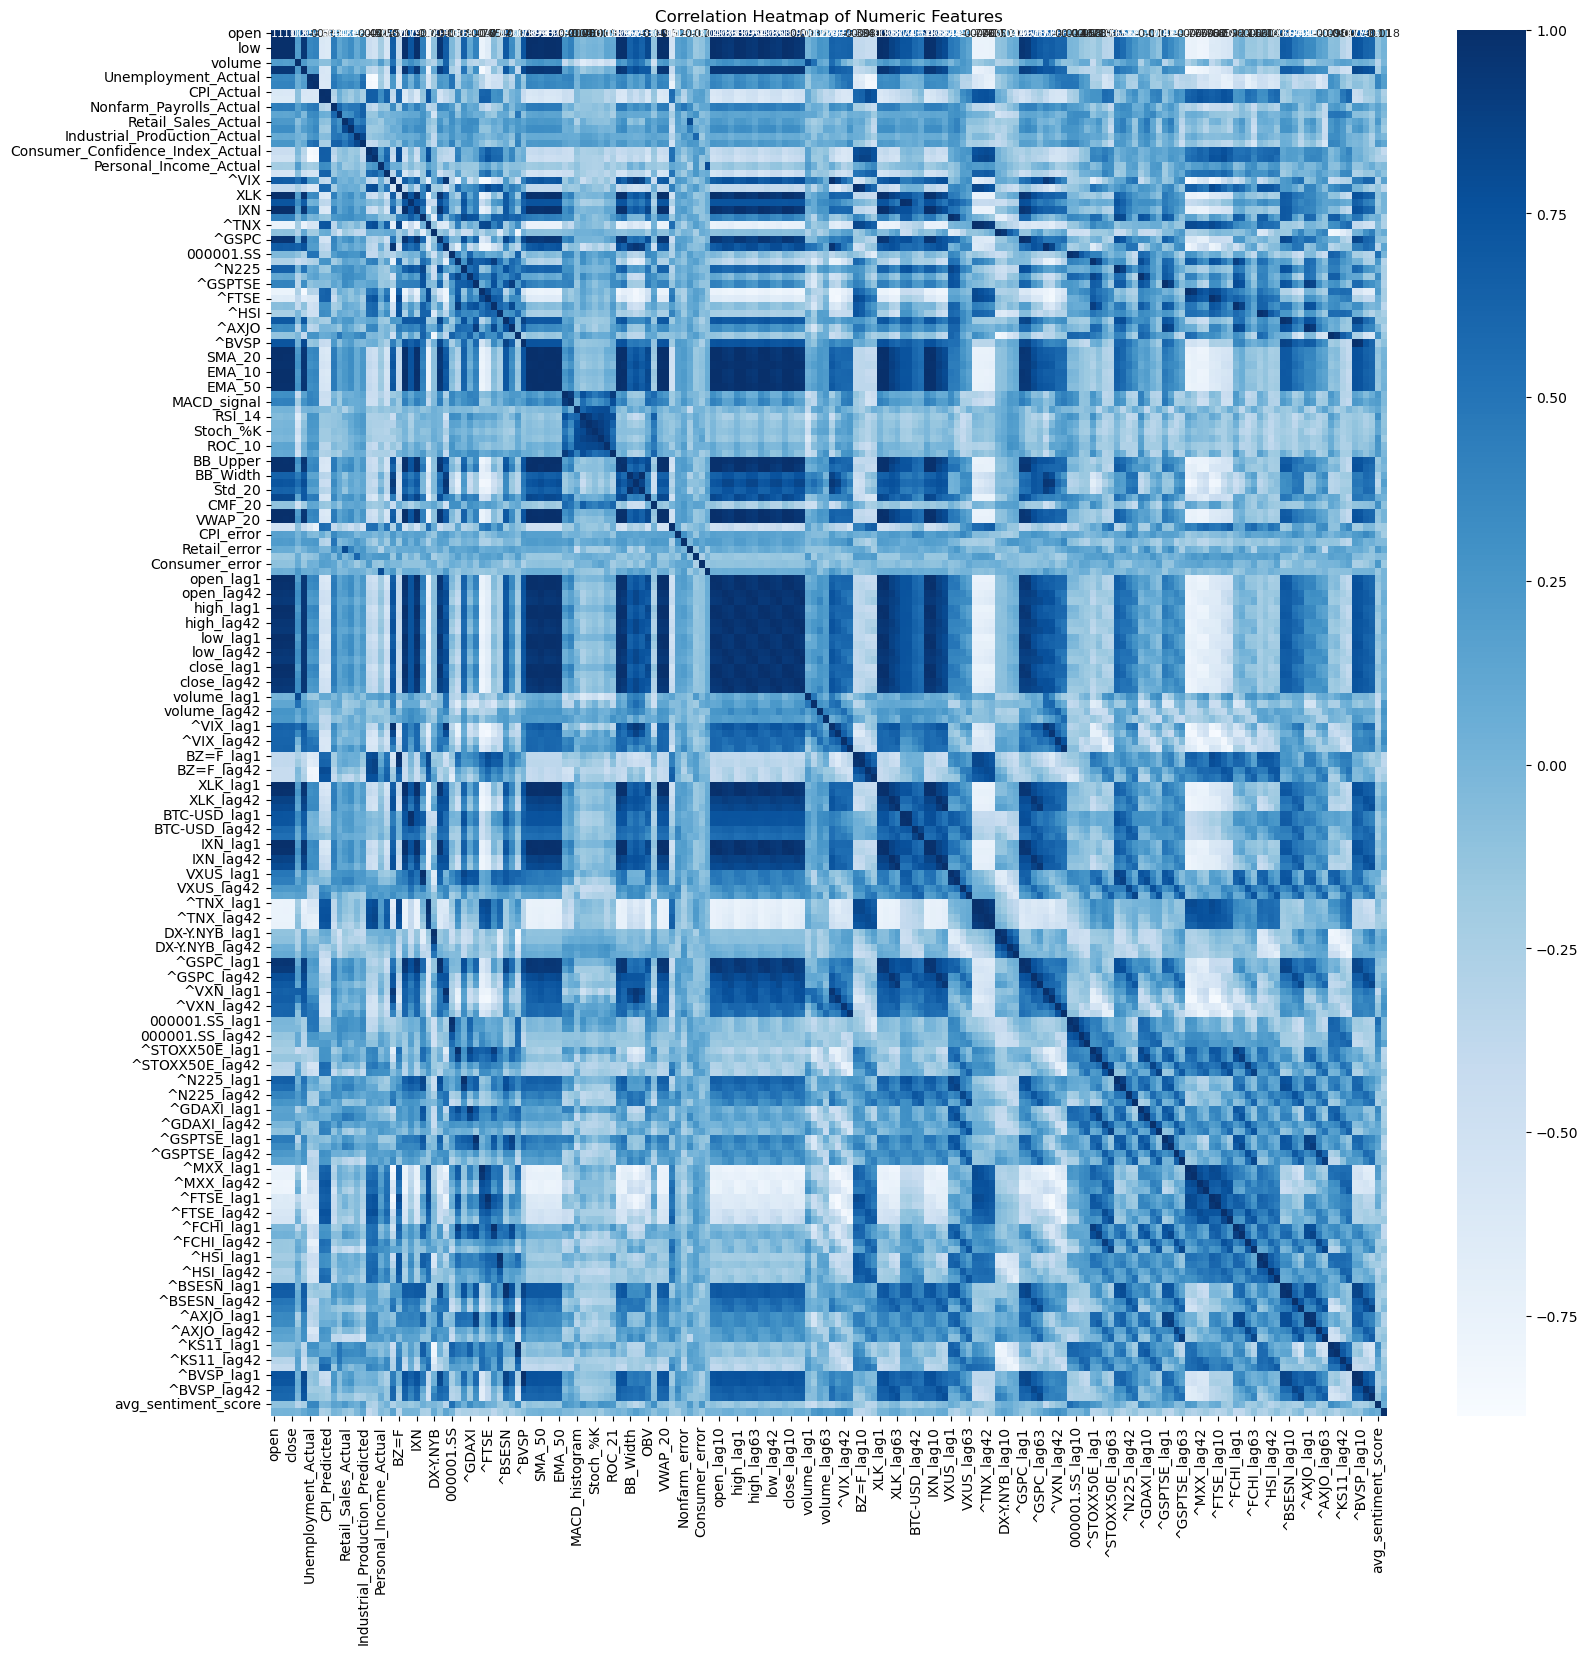

In [231]:
numeric_df = scaled_df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
plt.figure(figsize=(18, 18))
cor1 = numeric_df.corr()
sns.heatmap(cor1, annot=True, cmap="Blues", annot_kws={"size": 8})
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

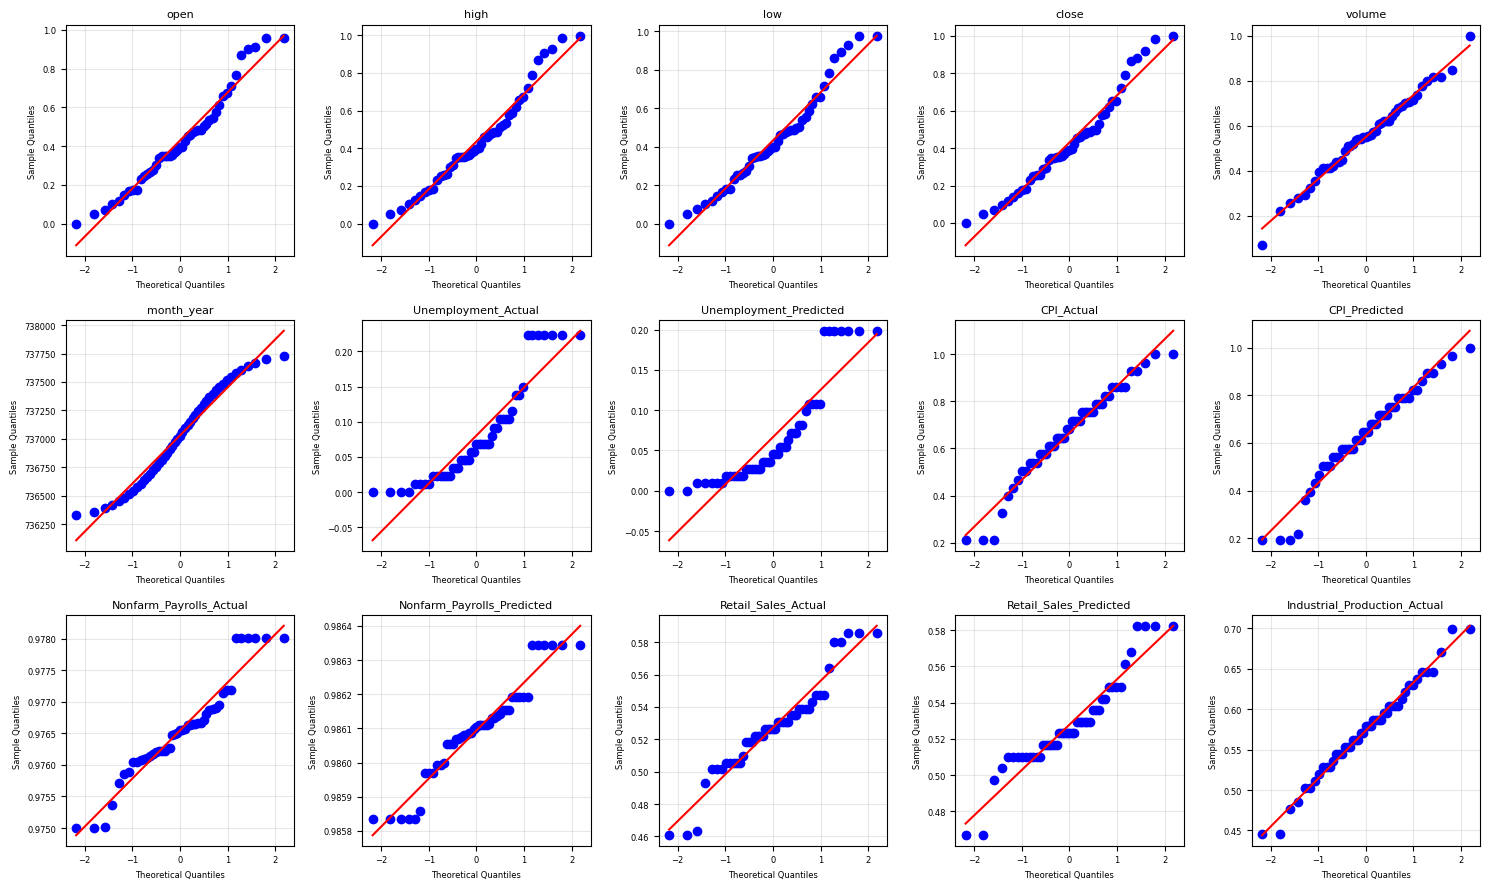

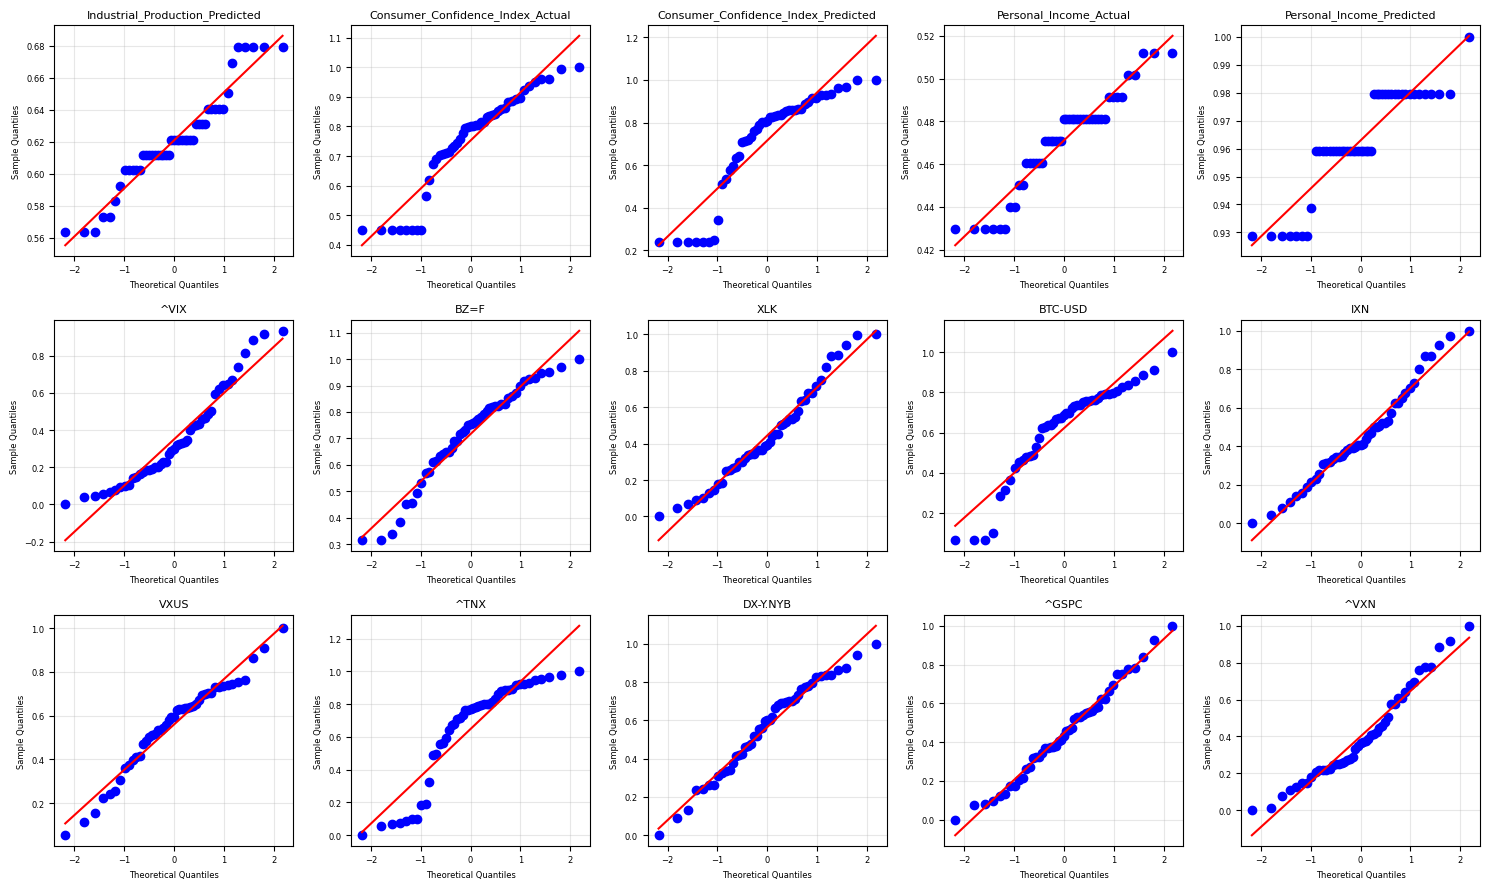

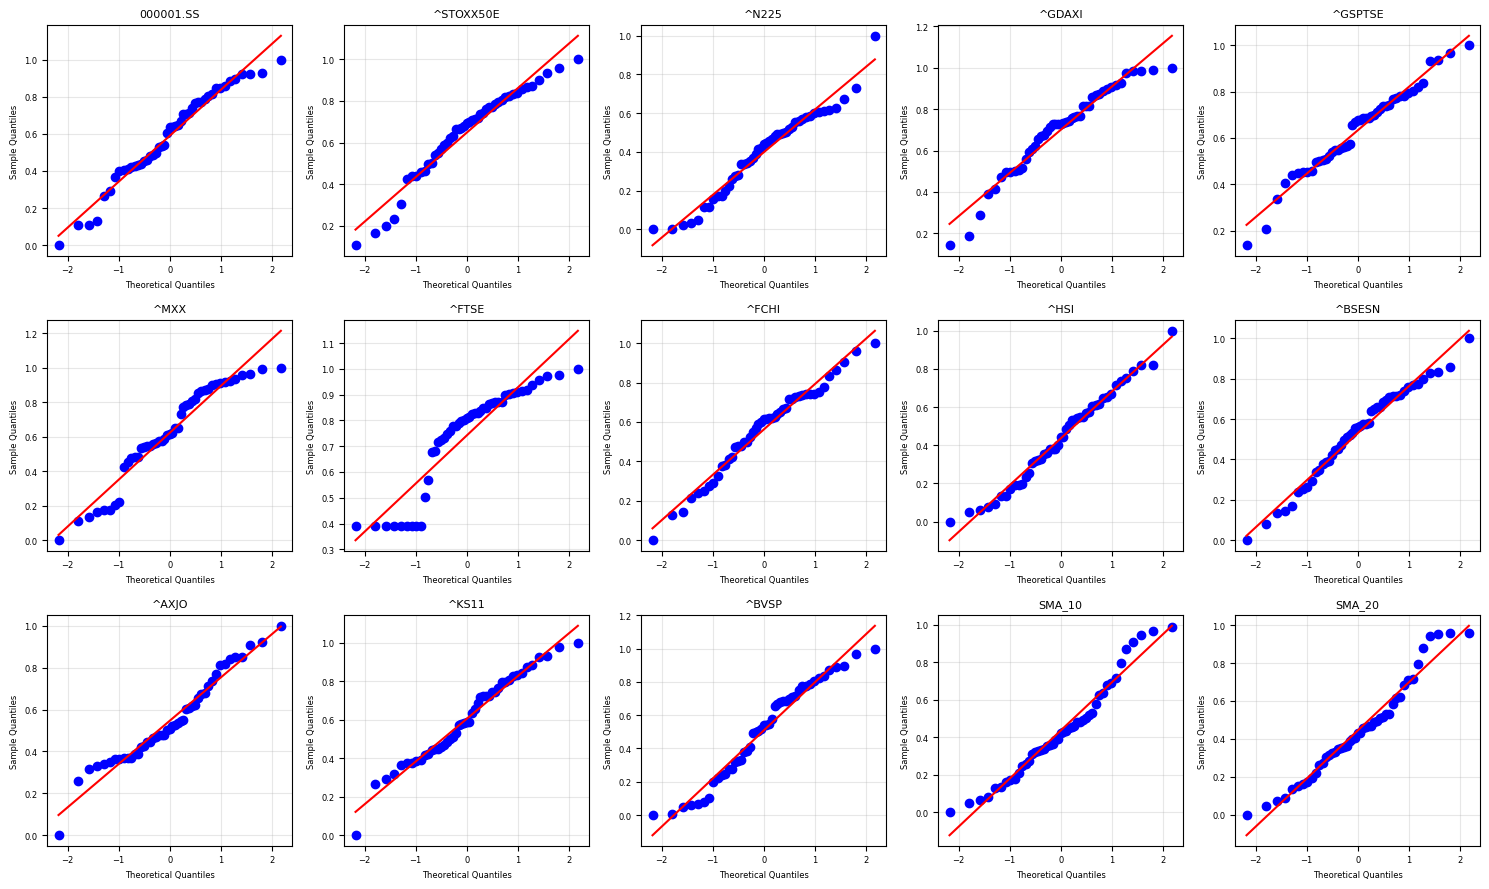

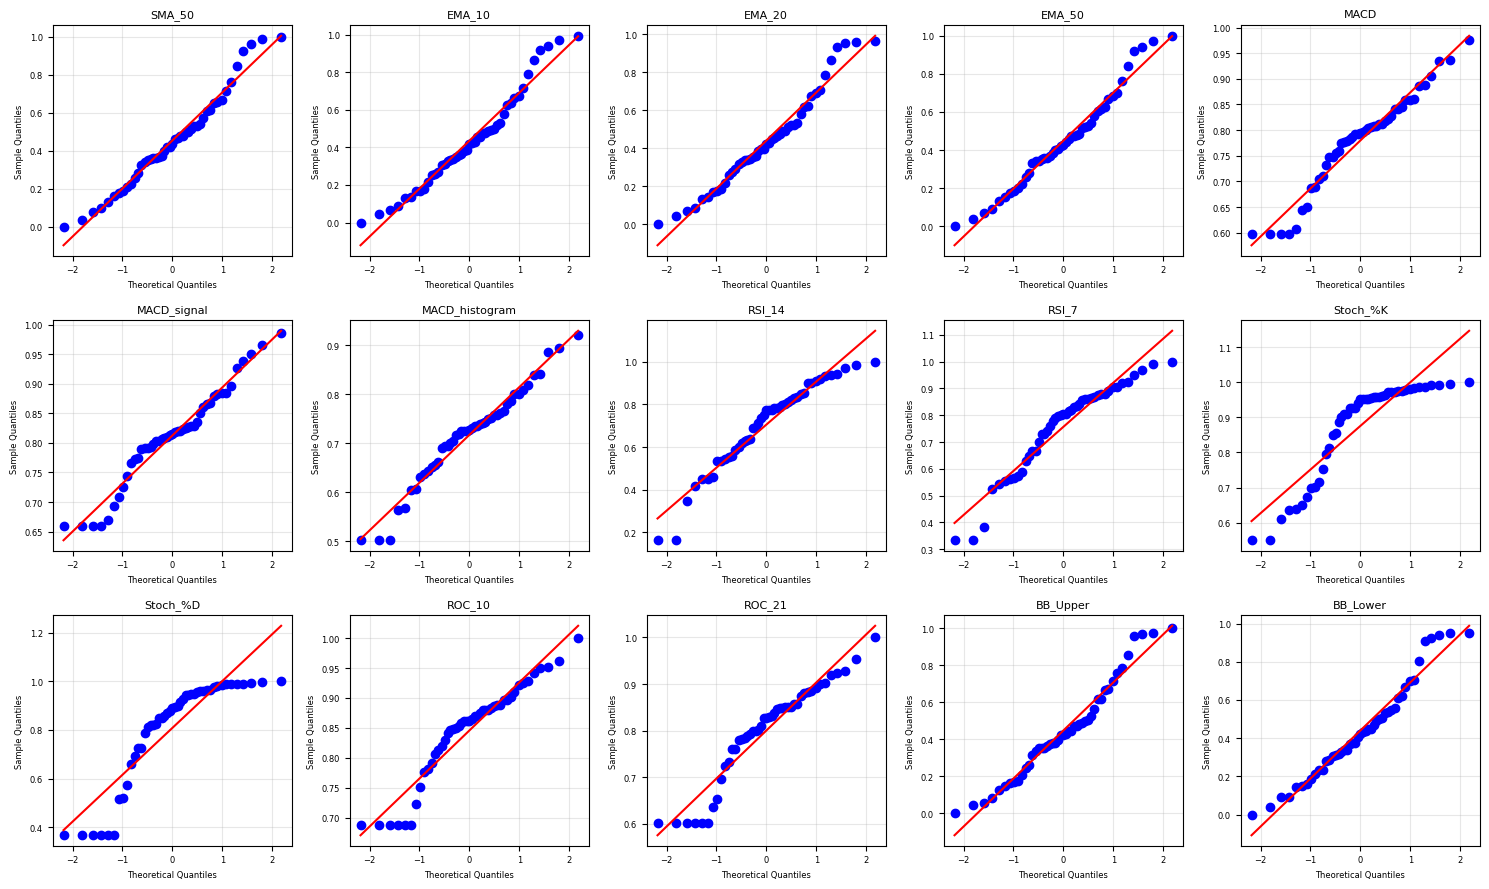

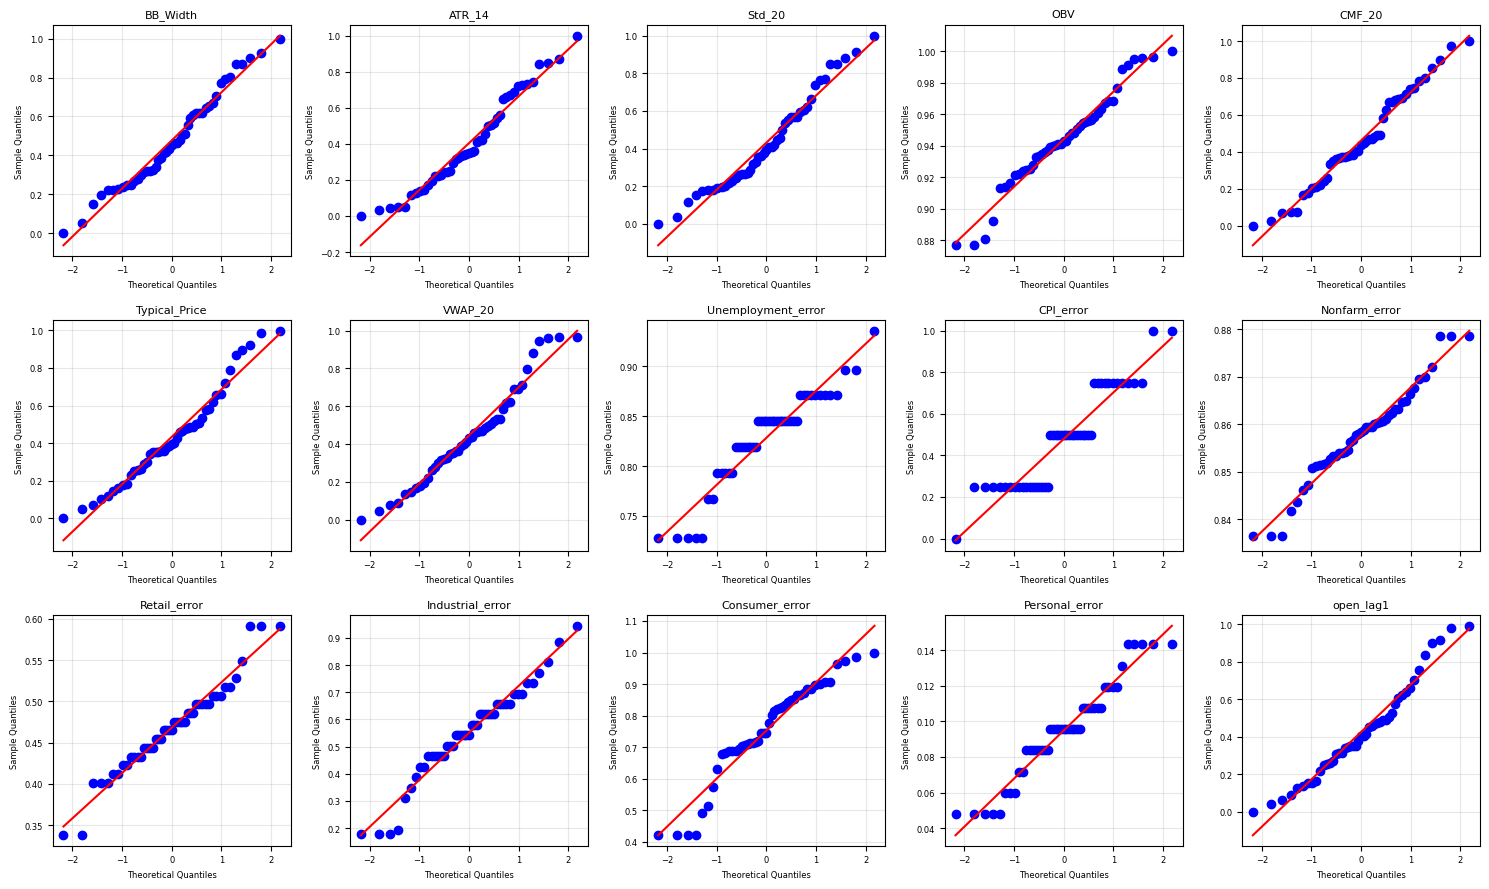

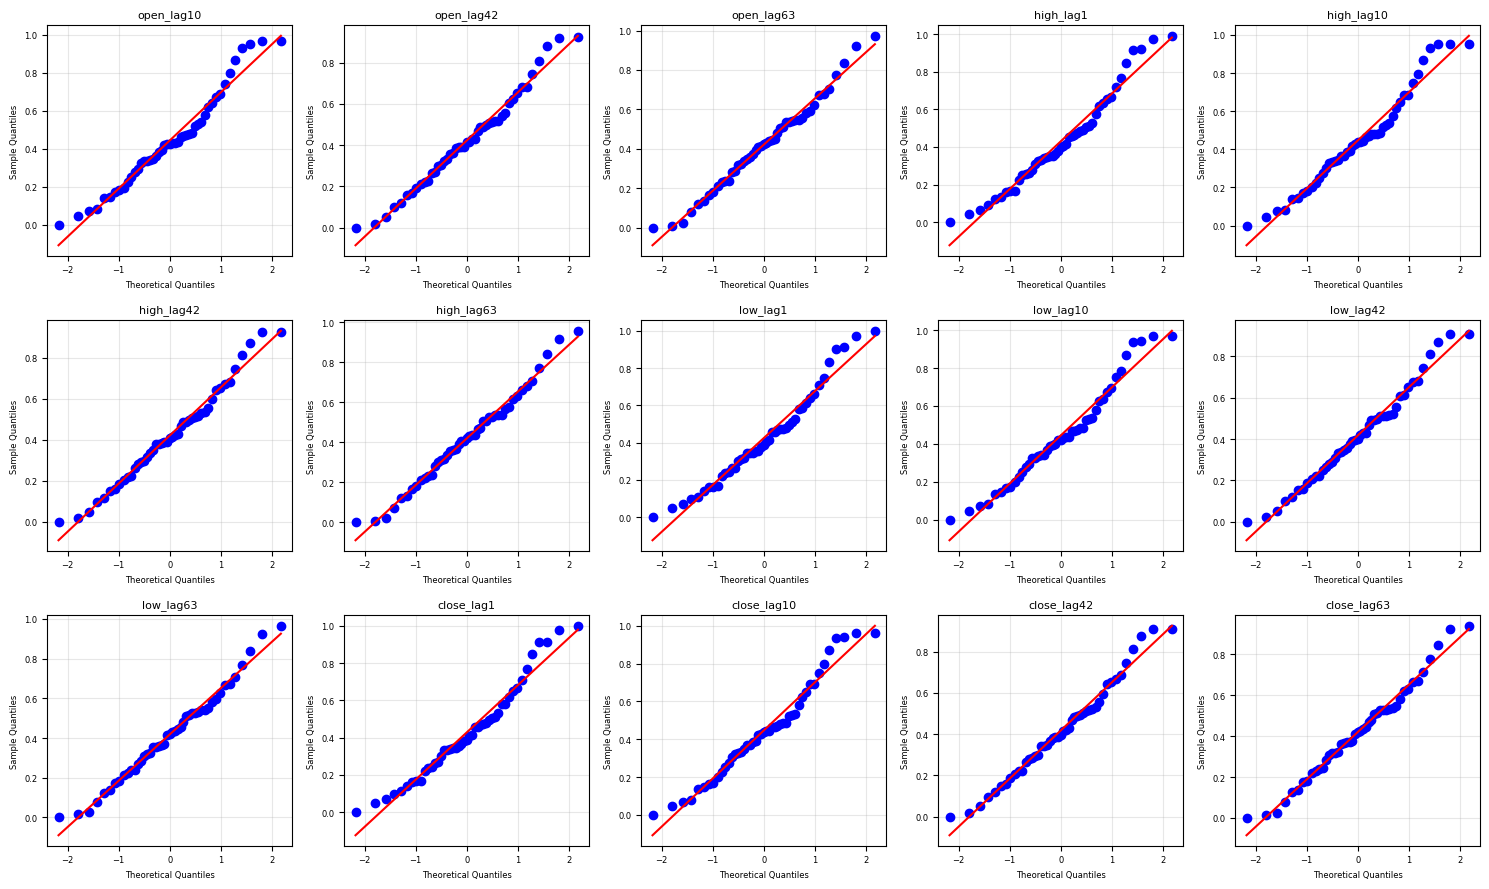

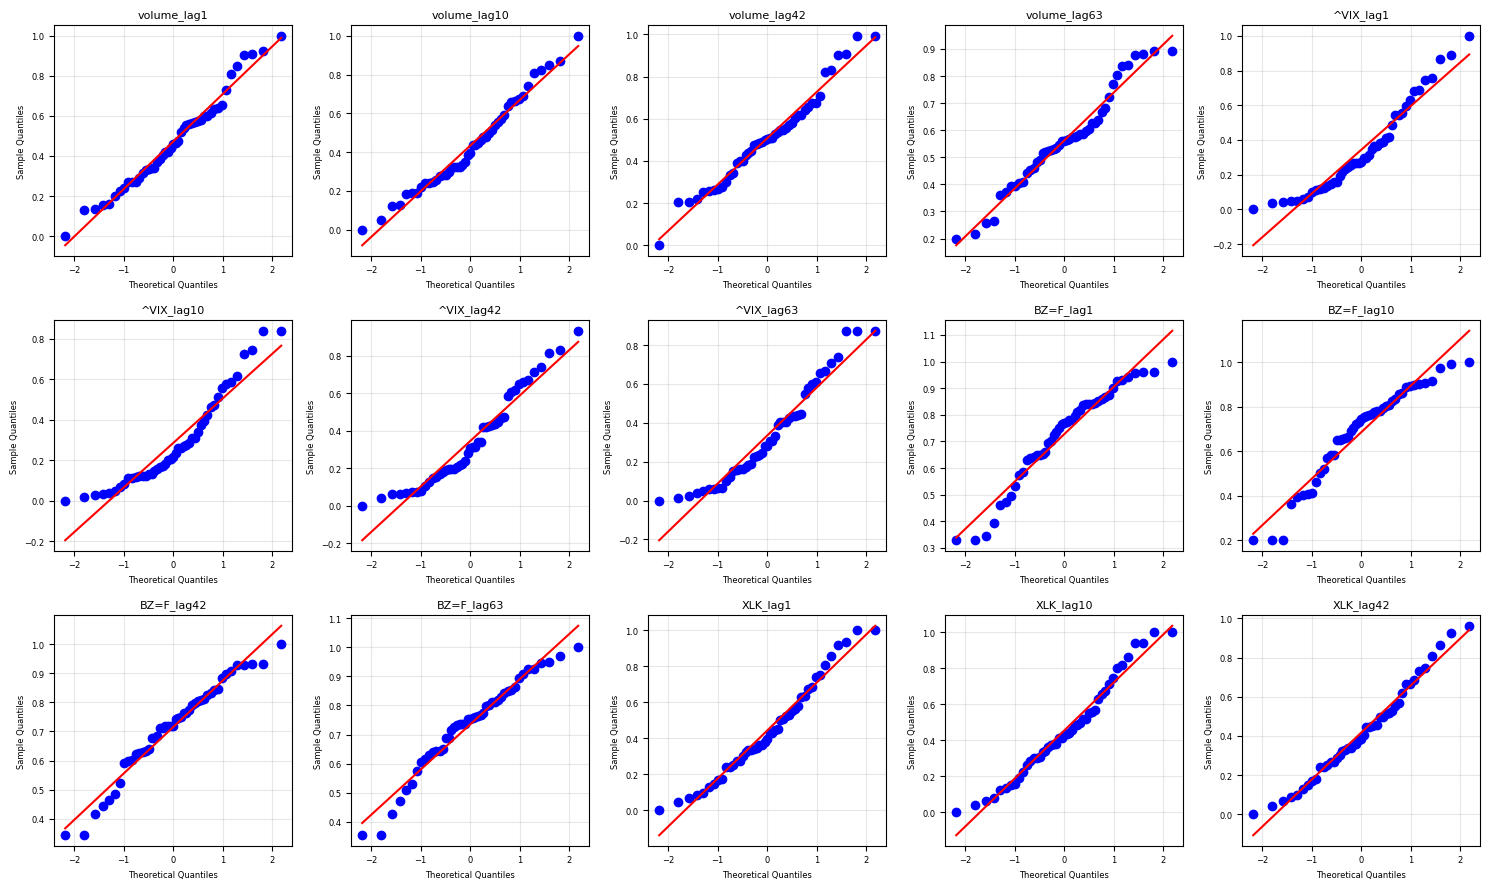

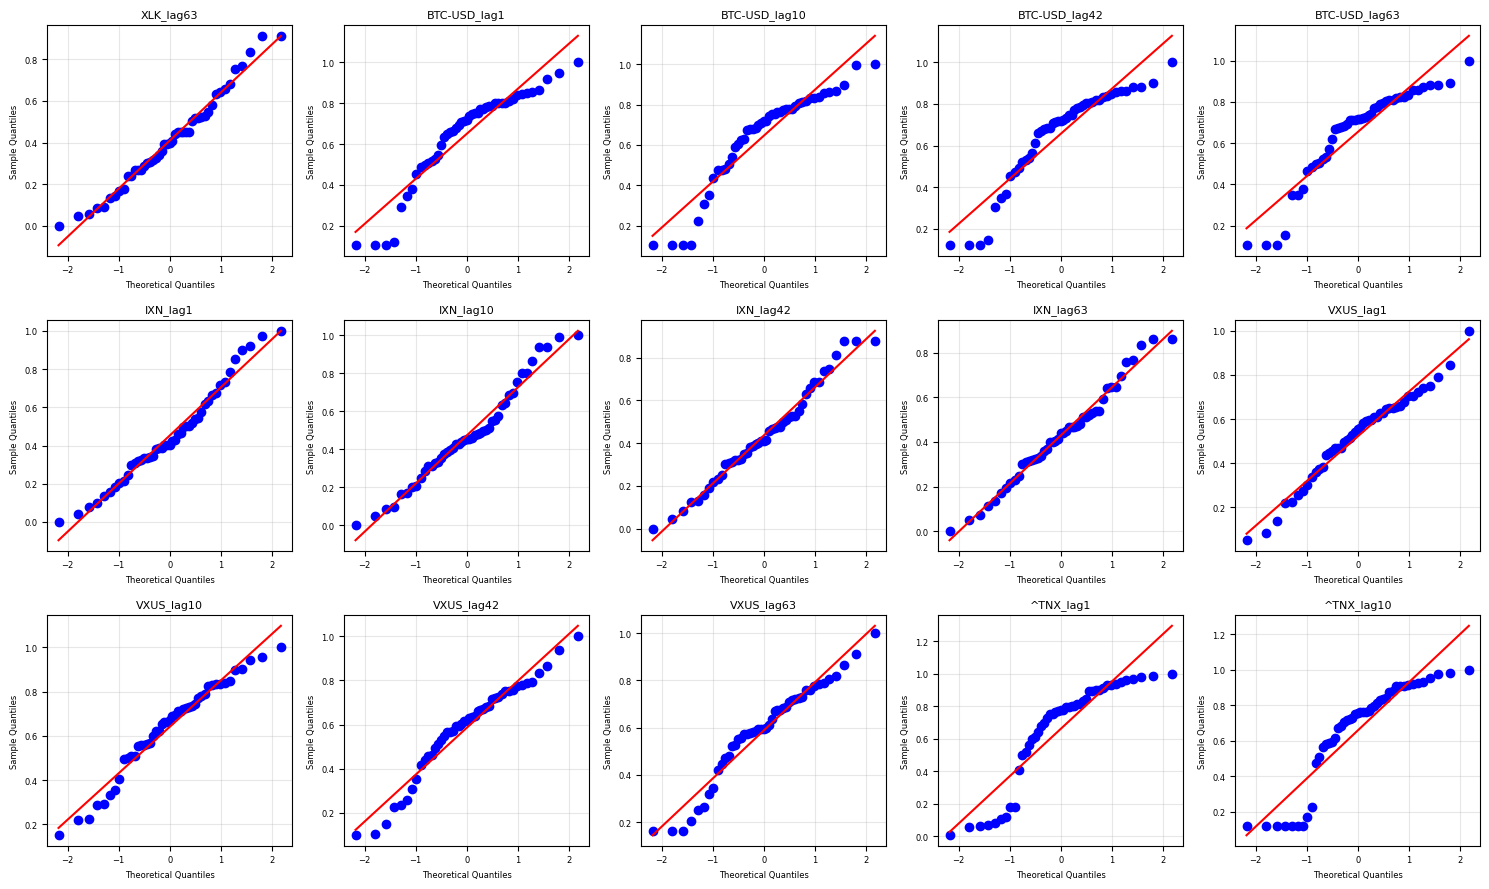

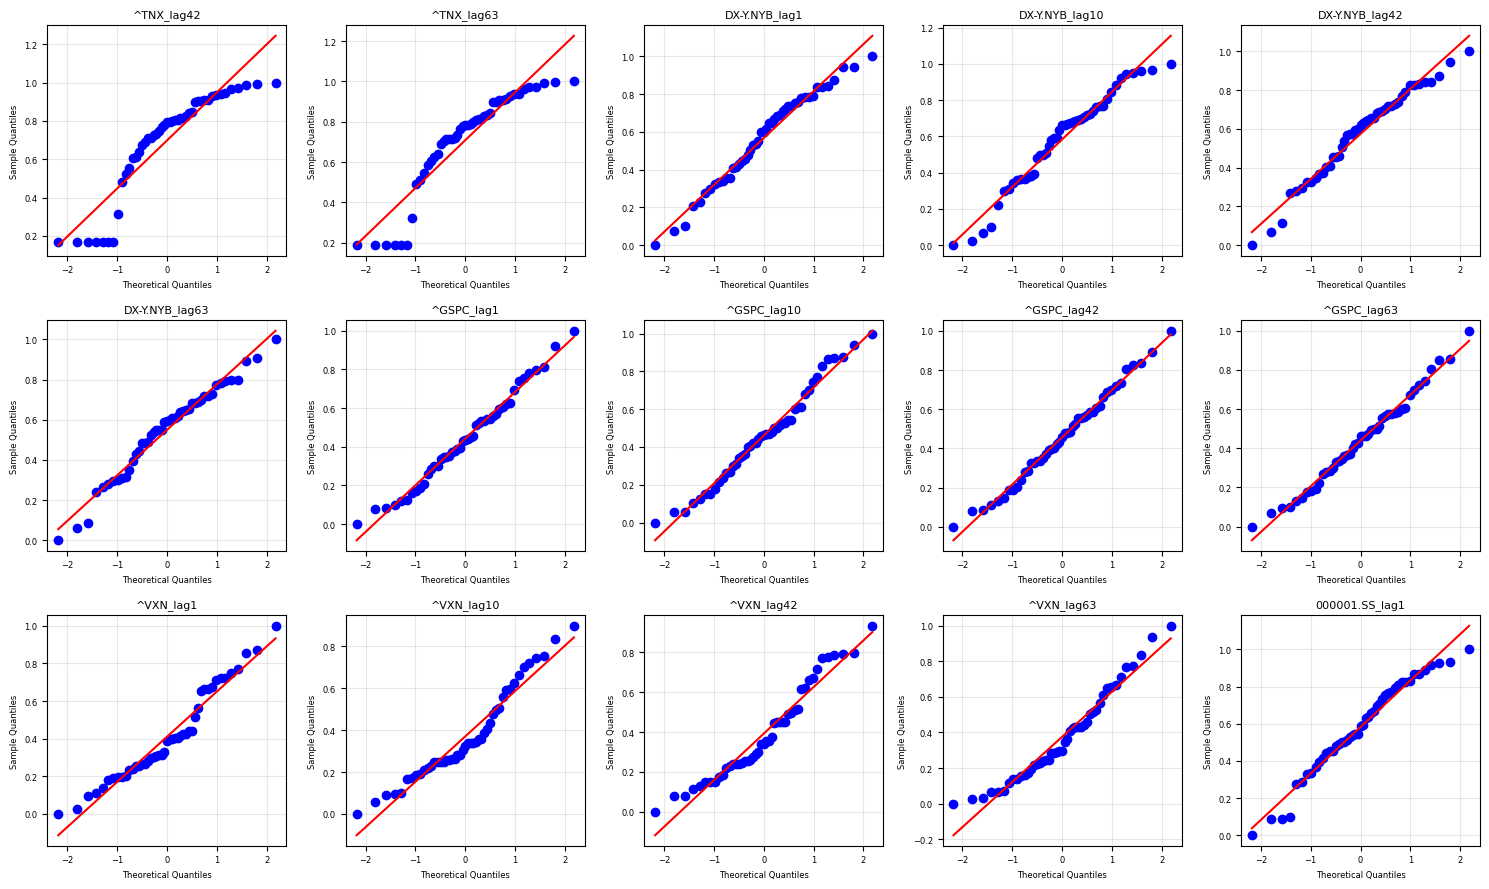

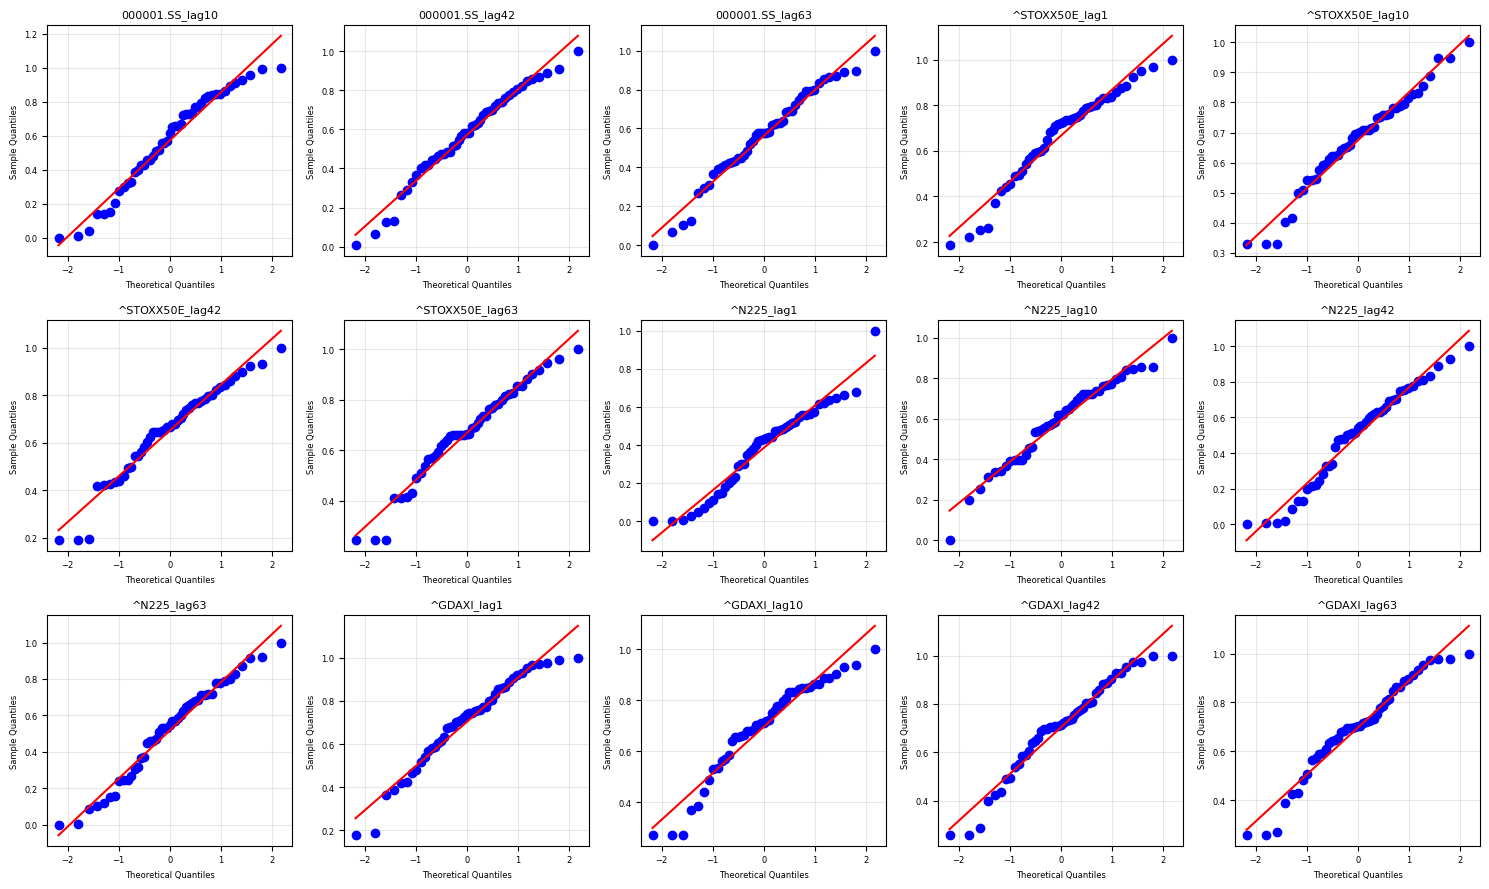

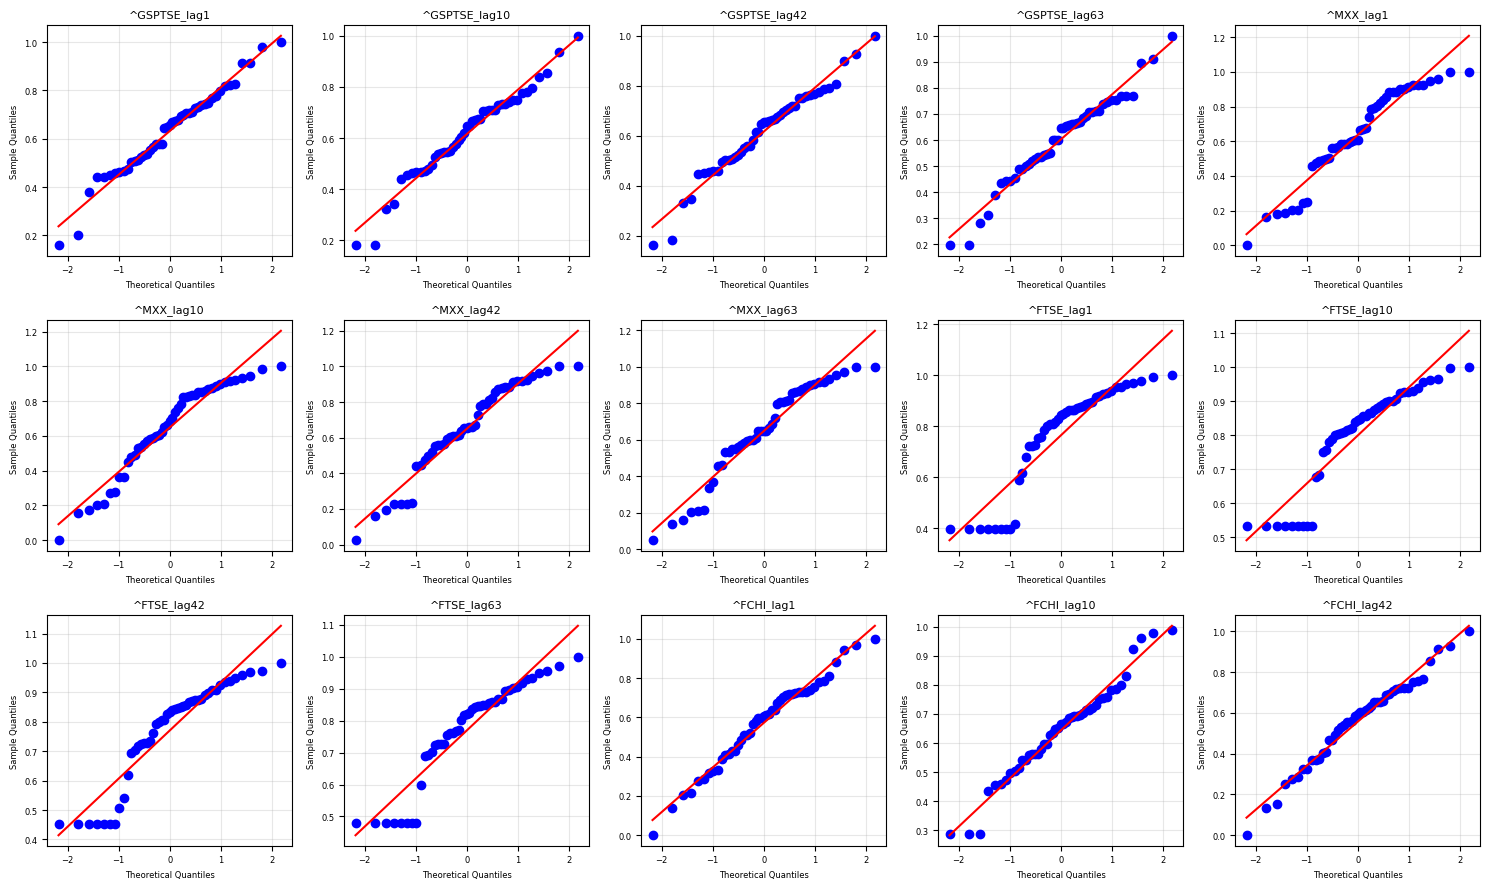

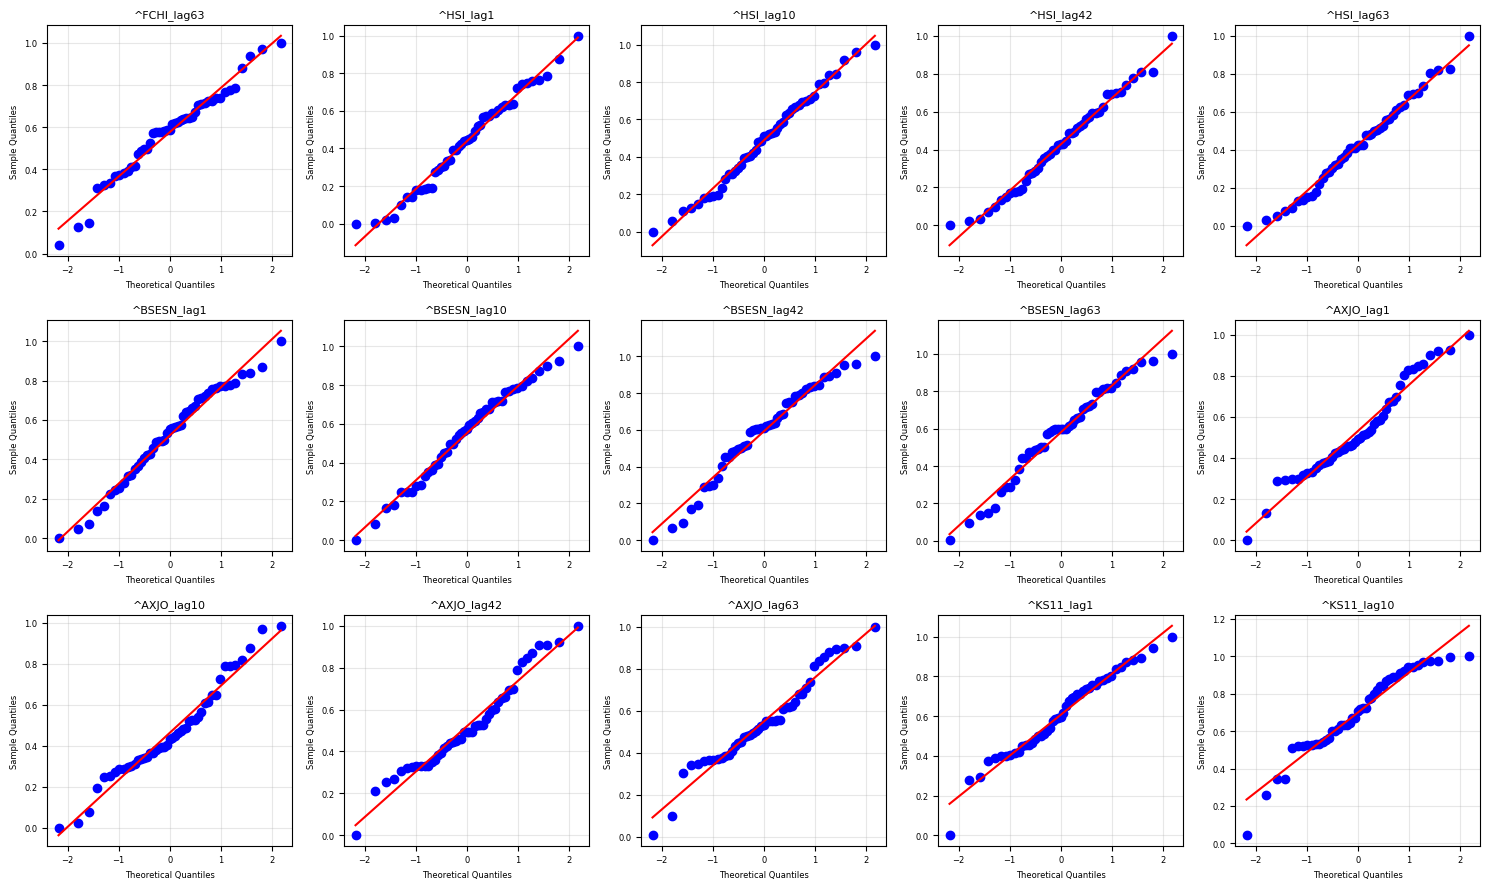

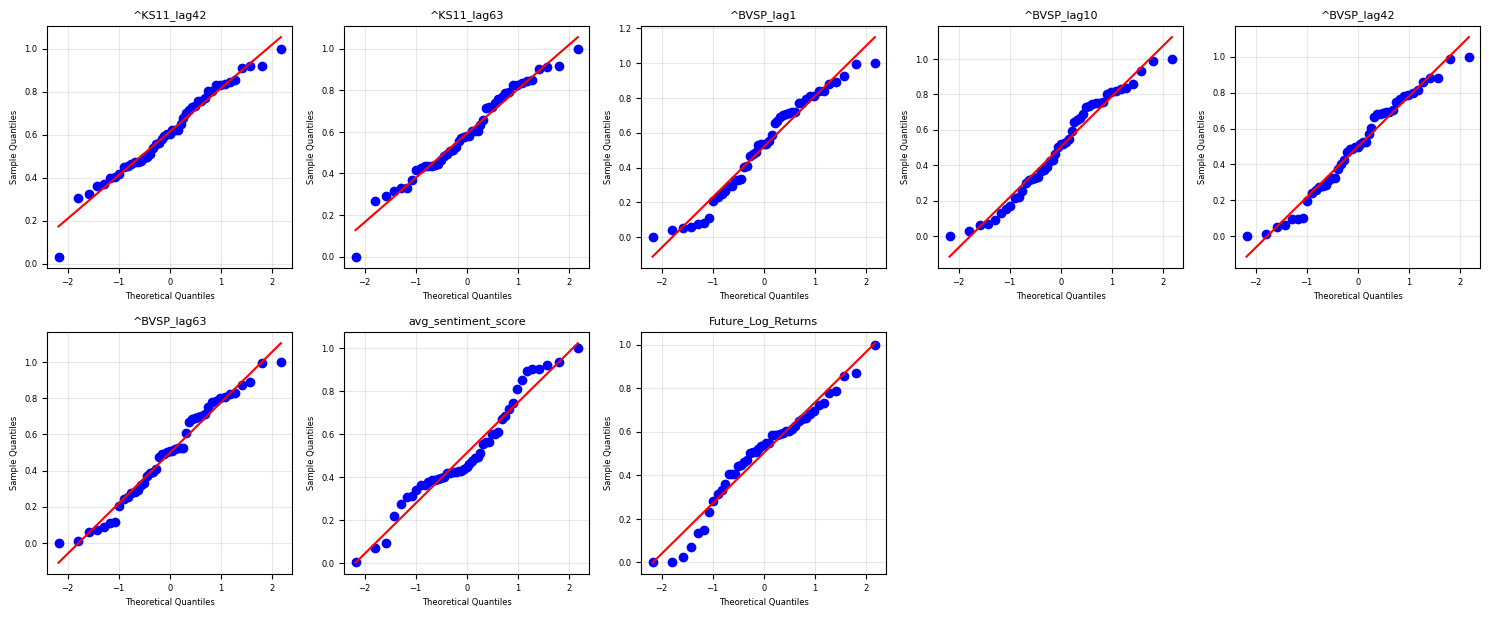

In [232]:
# Select numeric columns
numeric_df = scaled_df.select_dtypes(include=['int64', 'float64'])

# Get numerical columns
numerical_cols = numeric_df.columns

if not numerical_cols.size:
    print("No numerical columns found in the DataFrame.")
else:
    # Set grid parameters
    cols_per_figure = 5
    plots_per_figure = 15  # Number of plots per figure (adjustable)
    rows_per_figure = (plots_per_figure + cols_per_figure - 1) // cols_per_figure  # Ceiling division
    
    # Calculate number of figures needed
    num_figures = (len(numerical_cols) + plots_per_figure - 1) // plots_per_figure
    
    for fig_num in range(num_figures):
        start_idx = fig_num * plots_per_figure
        end_idx = min((fig_num + 1) * plots_per_figure, len(numerical_cols))
        current_cols = numerical_cols[start_idx:end_idx]
        
        if not current_cols.size:
            break
        
        # Create a new figure with dynamic rows
        fig, axes = plt.subplots(rows_per_figure, cols_per_figure, figsize=(15, 3 * rows_per_figure))
        axes = axes.flatten()  # Flatten for easier indexing
        
        for i, col in enumerate(current_cols):
            ax = axes[i]
            # Generate Q-Q plot
            probplot(numeric_df[col].dropna(), dist="norm", plot=ax)
            ax.set_title(col, fontsize=8)
            ax.set_xlabel('Theoretical Quantiles', fontsize=6)
            ax.set_ylabel('Sample Quantiles', fontsize=6)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='both', labelsize=6)
        
        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        # Adjust layout and display
        plt.tight_layout()
        plt.show()

# Train-Test Split

In [61]:
# Prepare Sequences
def prepare_sequences(df, seq_len=10, test_size=0.2):
    """Convert DataFrame into sequences for time series modeling."""
    for col in df.columns:
        if pd.api.types.is_period_dtype(df[col]):
            df[col] = df[col].apply(lambda x: x.to_timestamp().toordinal() if pd.notnull(x) else np.nan)
    
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('Future_Log_Returns', errors='ignore')
    for col in numerical_cols:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        df[col] = df[col].clip(q1 - 1.5 * iqr, q3 + 1.5 * iqr)
    df[numerical_cols] = df[numerical_cols].fillna(method='ffill').fillna(0)
    
    X_seq, y_seq = [], []
    for i in range(seq_len, len(df)):
        X_seq.append(df.iloc[i-seq_len:i][numerical_cols].values)
        y_seq.append(df.iloc[i]['Future_Log_Returns'])
    X_seq, y_seq = np.array(X_seq, dtype=float), np.array(y_seq, dtype=float)
    
    if not np.all(np.isfinite(X_seq)) or not np.all(np.isfinite(y_seq)):
        raise ValueError("Data contains NaN or infinite values")
    
    train_size = int((1 - test_size) * len(X_seq))
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_test, y_test = X_seq[train_size:], y_seq[train_size:]
    return X_train, y_train, X_test, y_test, numerical_cols

In [74]:
# Run
X_train, y_train, X_test, y_test, numerical_cols = prepare_sequences(scaled_df)

In [75]:
# Info
print('X_train : ') 
print(X_train.shape) 
print('') 
print('X_test : ') 
print(X_test.shape) 
print('') 
print('y_train : ') 
print(y_train.shape) 
print('') 
print('y_test : ') 
print(y_test.shape)

X_train : 
(29, 10, 187)

X_test : 
(8, 10, 187)

y_train : 
(29,)

y_test : 
(8,)


# Select Features

In [70]:
# Modified Select Features function that returns RFECV model
def select_features(X_train, y_train, X_test, numerical_cols, n_features=50):
    """Select top features using RFECV."""
    X_train_last = X_train[:, -1, :]
    estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    rfecv = RFECV(estimator, step=1, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
    rfecv.fit(X_train_last, y_train)
    
    selected_mask = rfecv.support_
    selected_features = numerical_cols[selected_mask]
    importances = rfecv.estimator_.feature_importances_
    feature_df = pd.DataFrame({'feature': selected_features, 'importance': importances}).sort_values('importance', ascending=False)
    top_features = feature_df.head(n_features)['feature'].tolist()
    selected_indices = [list(numerical_cols).index(f) for f in top_features]
    
    print(f"Selected {len(selected_indices)} features:")
    print(feature_df.head(n_features))
    
    # Return the RFECV model for plotting
    return X_train[:, :, selected_indices], X_test[:, :, selected_indices], selected_indices, rfecv

In [71]:
# Run feature selection and get RFECV model
X_train_sel, X_test_sel, sel_indices, rfecv = select_features(X_train, y_train, X_test, numerical_cols)

Selected 50 features:
                             feature  importance
72                        ^VXN_lag10    0.095380
76                   000001.SS_lag42    0.079458
36                     Nonfarm_error    0.061208
82                       ^N225_lag42    0.044207
4            Nonfarm_Payrolls_Actual    0.035530
48                        ^VIX_lag10    0.028841
90                        ^MXX_lag10    0.028659
46                      volume_lag42    0.023146
63                         VXUS_lag1    0.022174
80                        ^N225_lag1    0.022036
25                              MACD    0.021669
53                        BZ=F_lag42    0.019653
28                            RSI_14    0.018533
89                         ^MXX_lag1    0.018483
21                             ^FTSE    0.016503
52                        BZ=F_lag10    0.015021
98                       ^FCHI_lag63    0.014634
109                      ^BVSP_lag42    0.014062
11            Personal_Income_Actual    0.01369

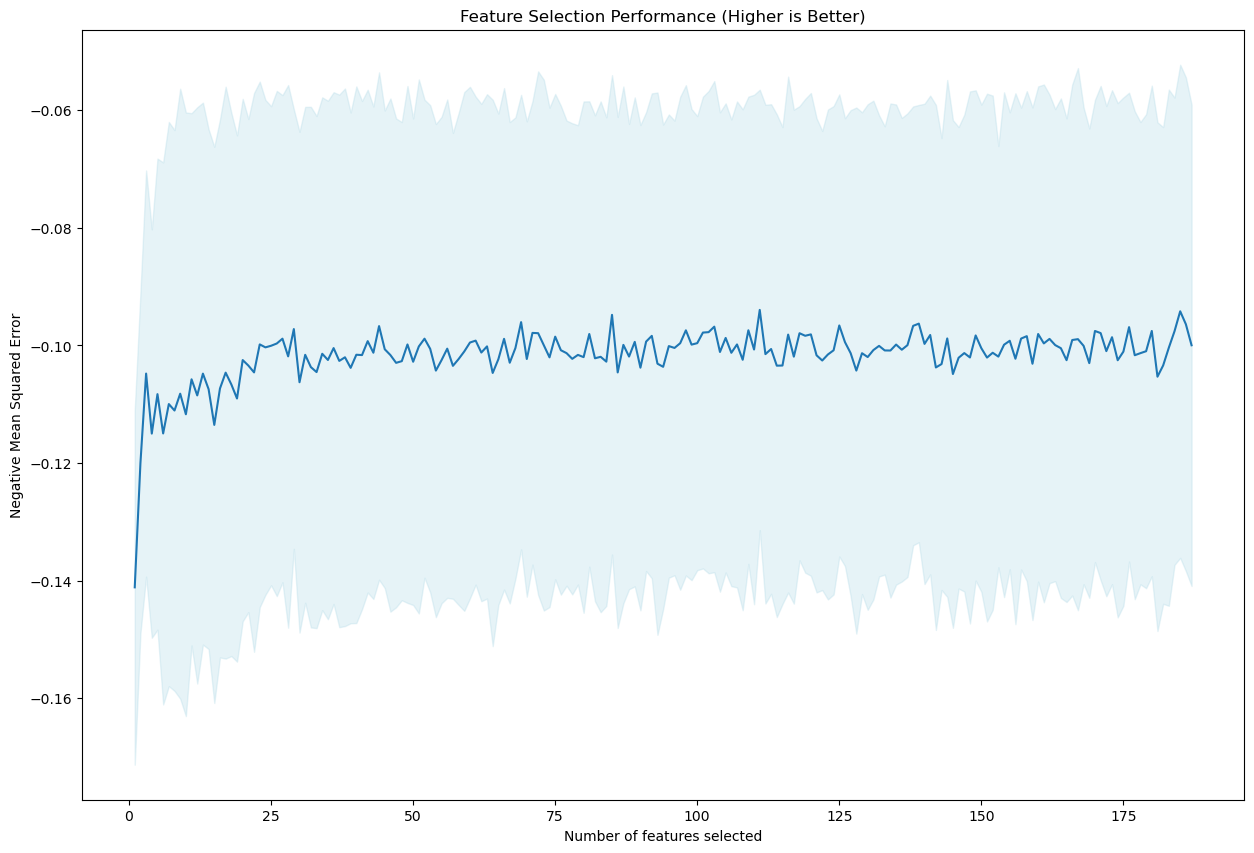

In [72]:
# plotting 
def plot_features_vs_cvscore(rfecv_model):
    n_features = len(rfecv_model.cv_results_["mean_test_score"])
    plt.figure(figsize=(15, 10))
    plt.xlabel("Number of features selected")
    plt.ylabel("Negative Mean Squared Error")
    plt.plot(range(1, n_features + 1), rfecv_model.cv_results_["mean_test_score"])
    plt.fill_between(range(1, n_features + 1), 
                     rfecv_model.cv_results_["mean_test_score"] - rfecv_model.cv_results_["std_test_score"], 
                     rfecv_model.cv_results_["mean_test_score"] + rfecv_model.cv_results_["std_test_score"], 
                     alpha=0.3, 
                     color="lightblue")
    plt.title("Feature Selection Performance (Higher is Better)")
    plt.show()

# Plot feature selection results
plot_features_vs_cvscore(rfecv)

# Convert to tensors
y_test: Unlike the training data, which is used to train the model in batches via a DataLoader, y_test is used solely for evaluation.

In [114]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train_sel, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_sel, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

# Data preparation for linear regression
X_train_lr = X_train_sel[:, -1, :]
X_test_lr = X_test_sel[:, -1, :]
X_train_lr_tensor = torch.tensor(X_train_lr, dtype=torch.float32)
X_test_lr_tensor = torch.tensor(X_test_lr, dtype=torch.float32)
train_dataset_lr = TensorDataset(X_train_lr_tensor, y_train_tensor)
train_loader_lr = DataLoader(train_dataset_lr, batch_size=64, shuffle=False)

In [115]:
# Print tensor shapes
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")

X_train_tensor shape: torch.Size([29, 10, 50])
y_train_tensor shape: torch.Size([29, 1])
X_test_tensor shape: torch.Size([8, 10, 50])
y_train_tensor shape: torch.Size([29, 1])


In [116]:
# Display a sample
print("Sample of X_train_tensor (first sequence):")
print(X_train_tensor[0])
print("Sample of y_train_tensor (first target):")
print(y_train_tensor[0])

Sample of X_train_tensor (first sequence):
tensor([[0.1649, 0.5821, 0.8542, 0.5123, 0.9762, 0.1107, 0.7384, 0.2646, 0.0850,
         0.0488, 0.7956, 0.7178, 0.8345, 0.7922, 0.7337, 0.6505, 0.5762, 0.5235,
         0.4708, 0.7374, 0.3323, 0.8810, 0.4186, 0.1364, 0.0513, 0.6960, 0.9796,
         0.2782, 0.6503, 0.5006, 0.7820, 0.6929, 0.5663, 0.5300, 0.4245, 0.2515,
         0.6131, 0.7116, 0.4303, 0.4678, 0.2842, 0.4517, 0.1047, 0.0000, 0.5486,
         0.0000, 0.7256, 0.7048, 0.4610, 0.0000],
        [0.0918, 0.5821, 0.8619, 0.5123, 0.9767, 0.0697, 0.8230, 0.2056, 0.1408,
         0.0071, 0.8117, 0.7178, 0.9735, 0.8057, 0.8033, 0.6526, 0.5762, 0.5235,
         0.4810, 0.7374, 0.0000, 0.9136, 0.4186, 0.1112, 0.1900, 0.6960, 0.9592,
         0.2193, 0.6021, 0.5908, 0.7742, 0.7027, 0.1973, 0.5841, 0.4245, 0.3358,
         0.6131, 0.7116, 0.4303, 0.4678, 0.3245, 0.4517, 0.1047, 0.0574, 0.5101,
         0.0367, 0.7256, 0.7697, 0.4610, 0.0153],
        [0.0000, 0.6884, 0.8602, 0.0000, 0.9767

# Define Models For Comparison

In [117]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    def forward(self, x):
        return self.linear(x)

In [118]:
class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(VanillaLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [119]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [120]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CNNLSTM, self).__init__()
        self.conv = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.transpose(1, 2)  # [batch, features, seq_len]
        x = self.conv(x)       # [batch, hidden_size, seq_len]
        x = x.transpose(1, 2)  # [batch, seq_len, hidden_size]
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Training Function

This function trains a PyTorch model using a training data loader, implements early stopping based on validation loss (computed on the test set), and returns the trained model.

Loss Function and Optimizer:
- nn.MSELoss() is appropriate for regression tasks, matching the context of predicting continuous values.
- optim.Adam with a learning rate of 0.0005 and weight_decay=1e-5 (for regularization) is a standard choice.

In [122]:
# Training function without CV
def train_model(model, train_loader, X_test, y_test, epochs=50, patience=5, lr=0.0005):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    best_loss = float('inf')
    trigger = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test).numpy().flatten()
            test_loss = mean_squared_error(y_test, y_pred_test)
            if test_loss < best_loss:
                best_loss = test_loss
                trigger = 0
            else:
                trigger += 1
                if trigger >= patience:
                    break
    return model

# Training function with Cross-Validation
def train_model_cv(model, X_train, y_train, X_test, y_test, epochs=50, patience=5, lr=0.0005, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_mse = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        print(f"Fold {fold+1}/{n_splits}")
        
        X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
        X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]
        
        train_dataset_fold = TensorDataset(torch.tensor(X_train_fold, dtype=torch.float32), 
                                           torch.tensor(y_train_fold, dtype=torch.float32).view(-1, 1))
        train_loader_fold = DataLoader(train_dataset_fold, batch_size=64, shuffle=False)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        best_loss = float('inf')
        trigger = 0
        
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            for X_batch, y_batch in train_loader_fold:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            avg_loss = running_loss / len(train_loader_fold)
            
            model.eval()
            with torch.no_grad():
                y_pred_val = model(torch.tensor(X_val_fold, dtype=torch.float32)).numpy().flatten()
                val_loss = mean_squared_error(y_val_fold, y_pred_val)
                if val_loss < best_loss:
                    best_loss = val_loss
                    trigger = 0
                else:
                    trigger += 1
                    if trigger >= patience:
                        print("Early stopping triggered")
                        break
        
        with torch.no_grad():
            y_pred_val = model(torch.tensor(X_val_fold, dtype=torch.float32)).numpy().flatten()
            mse_val = mean_squared_error(y_val_fold, y_pred_val)
            cv_mse.append(mse_val)
    
    # Train on full training set
    train_dataset_full = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                                       torch.tensor(y_train, dtype=torch.float32).view(-1, 1))
    train_loader_full = DataLoader(train_dataset_full, batch_size=64, shuffle=False)
    model = train_model(model, train_loader_full, X_test, y_test, epochs=epochs, patience=patience, lr=lr)
    
    return model, np.mean(cv_mse)

# Evaluation Function
This function evaluates the model on the test set, computes regression metrics, plots residuals, and returns the metrics.

In [124]:
# Evaluation function
def evaluate_model(model, X_test_tensor, y_test, model_name):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy().flatten()
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals')
    plt.title(f"{model_name} Residuals")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Residual Value")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{model_name}_residuals.png")
    plt.close()
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# 5-Folds cross validation

In [131]:
# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model configurations with seed set before initialization
model_configs = [
    ('Linear Regression', (torch.manual_seed(SEED), LinearRegressionModel(input_size=len(sel_indices)))[1], train_loader_lr, X_test_lr_tensor),
    ('Vanilla LSTM', (torch.manual_seed(SEED), VanillaLSTM(len(sel_indices), 100, 2, 1))[1], train_loader, X_test_tensor),
    ('Bidirectional LSTM', (torch.manual_seed(SEED), BidirectionalLSTM(len(sel_indices), 100, 2, 1))[1], train_loader, X_test_tensor),
    ('CNN-LSTM', (torch.manual_seed(SEED), CNNLSTM(len(sel_indices), 100, 2, 1))[1], train_loader, X_test_tensor)
]

# Training and evaluation with CV
results = {}
for name, model, loader, X_test in model_configs:
    print(f"\nTraining {name} with Cross-Validation...")
    trained_model, cv_mse = train_model_cv(model, X_train_sel if 'LSTM' in name or 'CNN' in name else X_train_lr, 
                                           y_train, X_test, y_test)
    print(f"Cross-Validated MSE for {name}: {cv_mse:.4f}")
    results[name] = evaluate_model(trained_model, X_test, y_test, name)


Training Linear Regression with Cross-Validation...
Fold 1/5
Early stopping triggered
Fold 2/5
Early stopping triggered
Fold 3/5
Early stopping triggered
Fold 4/5
Early stopping triggered
Fold 5/5
Early stopping triggered
Cross-Validated MSE for Linear Regression: 0.0883

Linear Regression Performance:
MSE: 0.0980, RMSE: 0.3131, MAE: 0.2850, R²: -0.6478

Training Vanilla LSTM with Cross-Validation...
Fold 1/5
Early stopping triggered
Fold 2/5
Early stopping triggered
Fold 3/5
Early stopping triggered
Fold 4/5
Early stopping triggered
Fold 5/5
Early stopping triggered
Cross-Validated MSE for Vanilla LSTM: 0.1155

Vanilla LSTM Performance:
MSE: 0.0775, RMSE: 0.2784, MAE: 0.2650, R²: -0.3026

Training Bidirectional LSTM with Cross-Validation...
Fold 1/5
Early stopping triggered
Fold 2/5
Early stopping triggered
Fold 3/5
Early stopping triggered
Fold 4/5
Early stopping triggered
Fold 5/5
Early stopping triggered
Cross-Validated MSE for Bidirectional LSTM: 0.0942

Bidirectional LSTM Perfor

In [132]:
print("\nModel Comparison Summary:")
for name, metrics in results.items():
    print(f"{name}: MSE={metrics['MSE']:.4f}, RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}, R²={metrics['R2']:.4f}")


Model Comparison Summary:
Linear Regression: MSE=0.0980, RMSE=0.3131, MAE=0.2850, R²=-0.6478
Vanilla LSTM: MSE=0.0775, RMSE=0.2784, MAE=0.2650, R²=-0.3026
Bidirectional LSTM: MSE=0.0666, RMSE=0.2581, MAE=0.2395, R²=-0.1197
CNN-LSTM: MSE=0.0709, RMSE=0.2662, MAE=0.2499, R²=-0.1914


# Plot validation loss

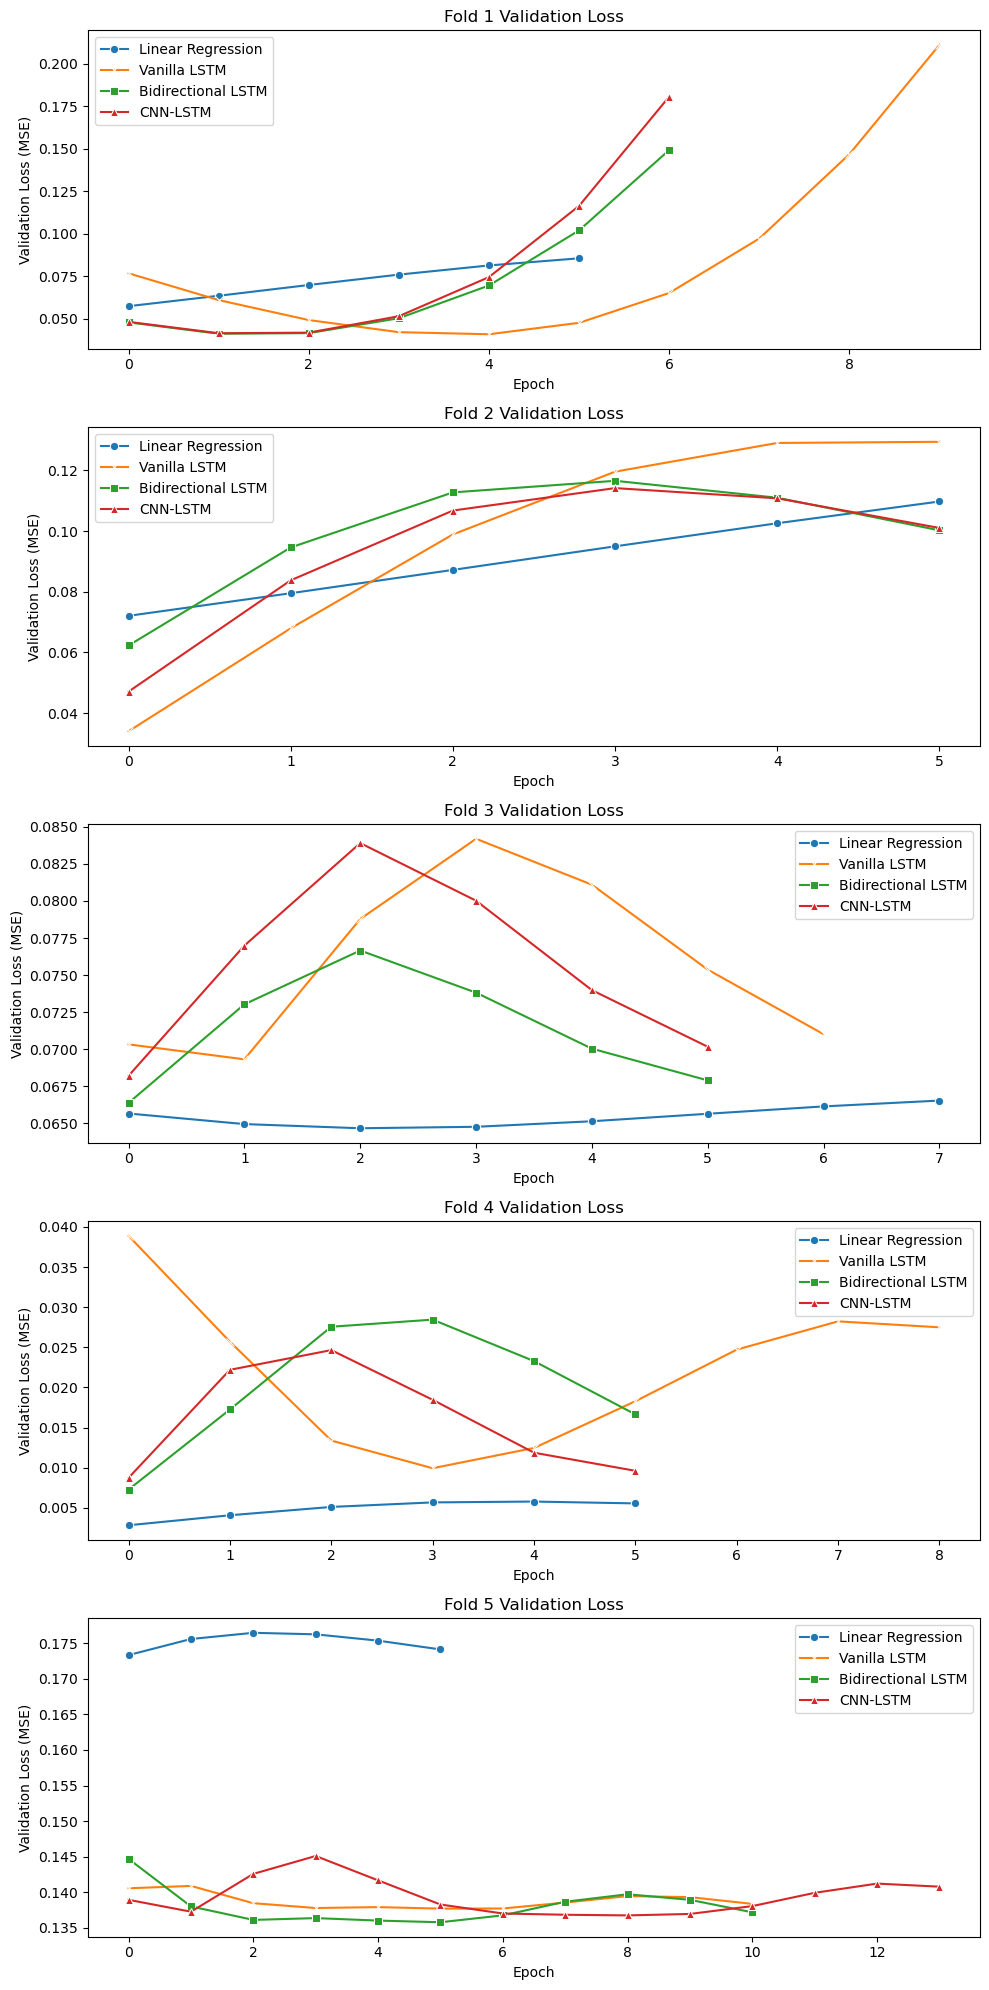

In [129]:
# Plot validation loss for each fold and model
n_folds = 5
fig, ax = plt.subplots(n_folds, figsize=(10, 20))
markers = {'Linear Regression': 'o', 'Vanilla LSTM': 'x', 'Bidirectional LSTM': 's', 'CNN-LSTM': '^'}

for i in range(n_folds):
    for name in val_loss_history.keys():
        val_losses = val_loss_history[name][i]
        sns.lineplot(
            x=np.arange(len(val_losses)), 
            y=val_losses, 
            ax=ax[i], 
            label=name, 
            marker=markers[name]
        )
    
    ax[i].set_title(f'Fold {i+1} Validation Loss')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Validation Loss (MSE)')
    ax[i].legend()

plt.tight_layout()
plt.show()

# Bidirectional LSTM is the best Model

In [130]:
pd.DataFrame(results)

Linear Regression  Vanilla LSTM  Bidirectional LSTM  CNN-LSTM
MSE            0.098020      0.077488            0.066609  0.070871
RMSE           0.313082      0.278366            0.258087  0.266216
MAE            0.285050      0.265049            0.239464  0.249905
R2            -0.647756     -0.302592           -0.119714 -0.191362

# Model Tuning on Bidirectional LSTM

In [142]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import itertools

# BidirectionalLSTM class
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0, activation=None):
        super(BidirectionalLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.norm = nn.BatchNorm1d(hidden_size * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = activation if activation is not None else nn.Identity()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.norm(out[:, -1, :])
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.activation(out)
        out = self.fc2(out)
        return out

# Training function with checkpointing
def train_model(model, train_loader, X_val_tensor, y_val_tensor, epochs, patience, lr):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)
    return model

# Tuning function
def tune_bidirectional_lstm(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, sel_indices):
    learning_rates = [0.001, 0.0005, 0.0001]
    hidden_sizes = [50, 100, 150]
    num_layers_list = [1, 2, 3]
    dropout_rates = [0.2, 0.3, 0.4]
    batch_sizes = [32, 64, 128]
    activations = [None, nn.Tanh(), nn.ReLU(), nn.LeakyReLU(), nn.ELU()]

    best_mse = float('inf')
    best_params = {}
    best_model = None

    param_combinations = list(itertools.product(learning_rates, hidden_sizes, num_layers_list, dropout_rates, batch_sizes, activations))

    for lr, hidden_size, num_layers, dropout, batch_size, activation in param_combinations:
        print(f"\nTesting: lr={lr}, hidden={hidden_size}, layers={num_layers}, dropout={dropout}, batch={batch_size}, activation={activation}")
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        model = BidirectionalLSTM(input_size=len(sel_indices), hidden_size=hidden_size, num_layers=num_layers, output_size=1, dropout=dropout, activation=activation)
        trained_model = train_model(model, train_loader, X_test_tensor, y_test_tensor, epochs=50, patience=5, lr=lr)
        metrics = evaluate_model(trained_model, X_test_tensor, y_test_tensor, f"BiLSTM (lr={lr}, hidden={hidden_size}, activation={activation})")

        if metrics['MSE'] < best_mse:
            best_mse = metrics['MSE']
            best_params = {
                'lr': lr,
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'dropout': dropout,
                'batch_size': batch_size,
                'activation': activation
            }
            best_model = trained_model
            

    print("\nBest Hyperparameters:", best_params)
    print(f"Best MSE: {best_mse:.4f}")
    return best_model, best_params

# Evaluation function
def evaluate_model(model, X_test_tensor, y_test_tensor, name):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        mse = nn.MSELoss()(predictions, y_test_tensor).item()
    return {'MSE': mse}

# Convert data to tensors before tuning
X_train_tensor = torch.tensor(X_train_sel, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_sel, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Run the tuning
best_model, best_params = tune_bidirectional_lstm(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, sel_indices)
final_metrics = evaluate_model(best_model, X_test_tensor, y_test_tensor, "Best Bidirectional LSTM")
print("\nFinal Model Performance:")
for key, value in final_metrics.items():
    print(f"{key}: {value:.4f}")


Testing: lr=0.001, hidden=50, layers=1, dropout=0.2, batch=32, activation=None

Testing: lr=0.001, hidden=50, layers=1, dropout=0.2, batch=32, activation=Tanh()
Early stopping at epoch 46

Testing: lr=0.001, hidden=50, layers=1, dropout=0.2, batch=32, activation=ReLU()

Testing: lr=0.001, hidden=50, layers=1, dropout=0.2, batch=32, activation=LeakyReLU(negative_slope=0.01)

Testing: lr=0.001, hidden=50, layers=1, dropout=0.2, batch=32, activation=ELU(alpha=1.0)
Early stopping at epoch 28

Testing: lr=0.001, hidden=50, layers=1, dropout=0.2, batch=64, activation=None

Testing: lr=0.001, hidden=50, layers=1, dropout=0.2, batch=64, activation=Tanh()
Early stopping at epoch 46

Testing: lr=0.001, hidden=50, layers=1, dropout=0.2, batch=64, activation=ReLU()

Testing: lr=0.001, hidden=50, layers=1, dropout=0.2, batch=64, activation=LeakyReLU(negative_slope=0.01)

Testing: lr=0.001, hidden=50, layers=1, dropout=0.2, batch=64, activation=ELU(alpha=1.0)
Early stopping at epoch 37

Testing: lr

# Model Saving

In [144]:
best_model

BidirectionalLSTM(
  (lstm1): LSTM(50, 150, batch_first=True, bidirectional=True)
  (lstm2): LSTM(300, 150, batch_first=True, bidirectional=True)
  (norm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=300, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=1, bias=True)
  (activation): Identity()
)

In [143]:
torch.save(best_model.state_dict(), 'best_model.pth')

# Finalise the Model

In [161]:
# Define the Bidirectional LSTM model architecture (matching the saved model)
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0, activation=None):
        super(BidirectionalLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.norm = nn.BatchNorm1d(hidden_size * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = activation if activation is not None else nn.Identity()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.norm(out[:, -1, :])  # Use the last time step’s output
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.activation(out)
        out = self.fc2(out)
        return out

# Load the Saved Model
input_size = 50   # Number of features per time step
hidden_size = 150
num_layers = 1
output_size = 1
dropout = 0.2
activation = None  # Identity

best_model = BidirectionalLSTM(input_size, hidden_size, num_layers, output_size, dropout, activation)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

BidirectionalLSTM(
  (lstm1): LSTM(50, 150, batch_first=True, bidirectional=True)
  (lstm2): LSTM(300, 150, batch_first=True, bidirectional=True)
  (norm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=300, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=1, bias=True)
  (activation): Identity()
)

In [162]:
# Model Performance
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    predictions = best_model(X_test_tensor).numpy()

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 0.0568
Root Mean Squared Error (RMSE): 0.2382
Mean Absolute Error (MAE): 0.2032
R-squared (R²): 0.0460


In [198]:
predictions.flatten()

array([0.5914546 , 0.5916501 , 0.5771352 , 0.55852413, 0.558867  ,
       0.54492205, 0.576754  , 0.60540026], dtype=float32)

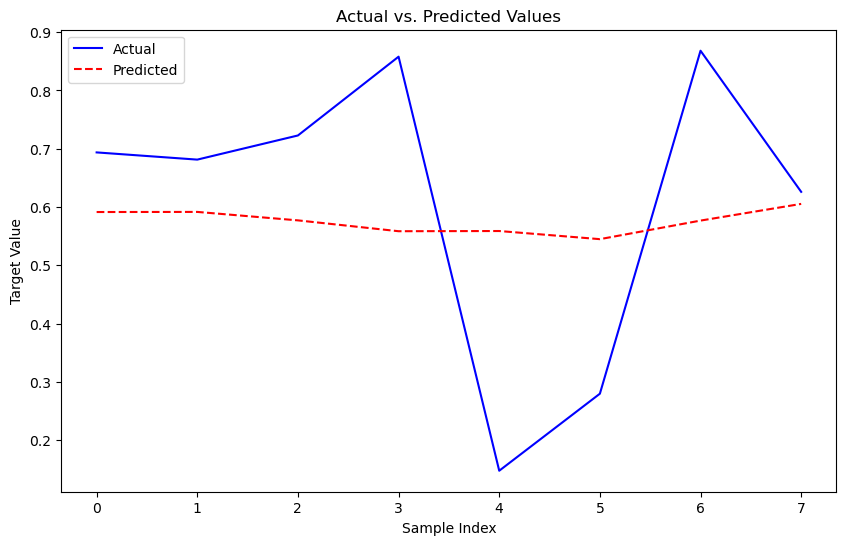

In [163]:
# Plot Predictions vs. Actuals
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

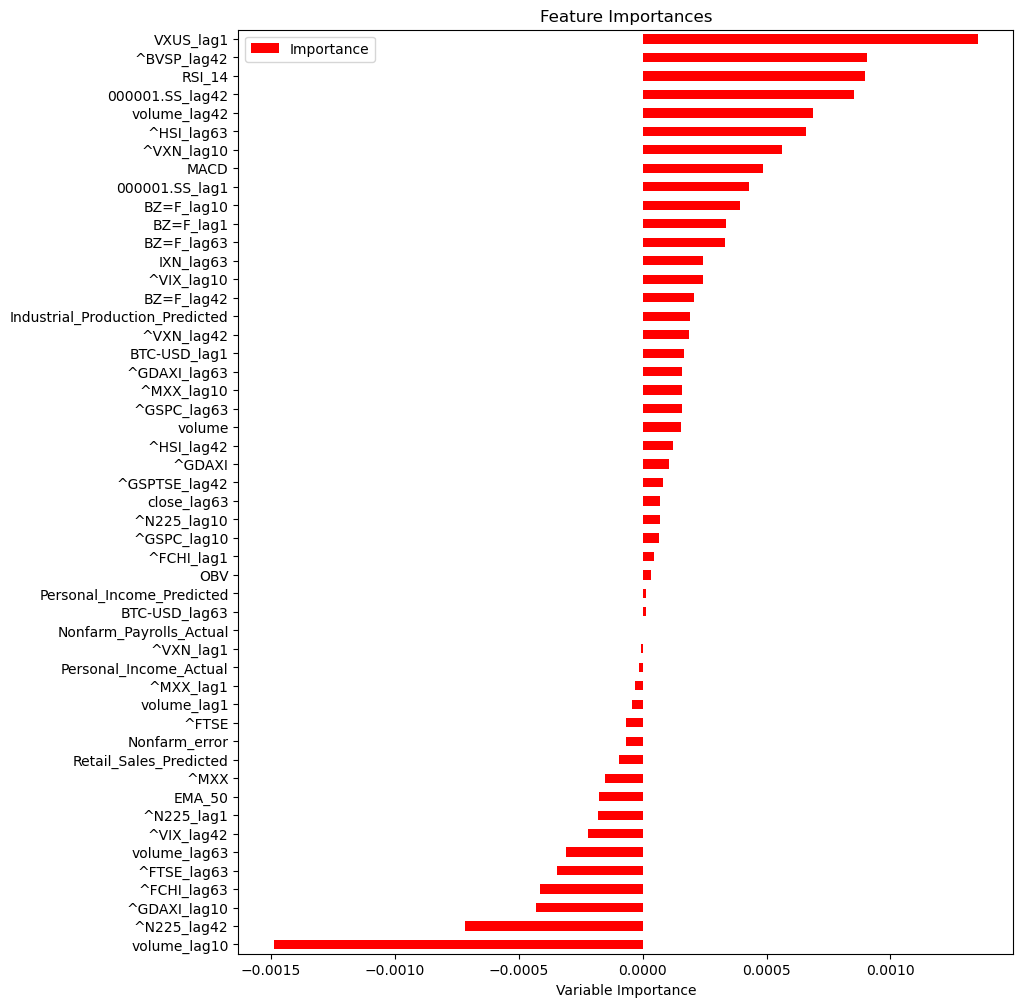

In [168]:
# Feature Importance Analysis

# Define a wrapper class to make the PyTorch model compatible with scikit-learn
class PreTrainedModel:
    def __init__(self, model, sequence_length, input_size):
        self.model = model
        self.sequence_length = sequence_length
        self.input_size = input_size

    def fit(self, X, y=None):
        # Since the model is pre-trained, fit does nothing
        return self

    def predict(self, X):
        # X is 2D: (n_samples, sequence_length * input_size)
        n_samples = X.shape[0]
        # Reshape to 3D: (n_samples, sequence_length, input_size) for the LSTM
        X_reshaped = X.reshape(n_samples, self.sequence_length, self.input_size)
        X_tensor = torch.tensor(X_reshaped, dtype=torch.float32)
        with torch.no_grad():
            return self.model(X_tensor).numpy()

# Extract sequence_length from X_test shape
sequence_length = X_test.shape[1]

# Instantiate the wrapper with the pre-trained model
pretrained_estimator = PreTrainedModel(best_model, sequence_length, input_size)

# Reshape X_test to 2D for permutation_importance: (n_samples, sequence_length * input_size)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Calculate permutation importance
result = permutation_importance(
    pretrained_estimator,
    X_test_flat,
    y_test,
    scoring='neg_mean_squared_error',
    n_repeats=10,
    random_state=42
)

importances = result.importances_mean

# Aggregate importances for each feature across time steps
aggregated_importances = []
for k in range(input_size):
    importance_k = sum(importances[t * input_size + k] for t in range(sequence_length))
    aggregated_importances.append(importance_k)

# Define feature names with actual names in the order they appear in X_test
feature_names = [
    '^VXN_lag10', '000001.SS_lag42', 'Nonfarm_error', '^N225_lag42', 'Nonfarm_Payrolls_Actual',
    '^VIX_lag10', '^MXX_lag10', 'volume_lag42', 'VXUS_lag1', '^N225_lag1',
    'MACD', 'BZ=F_lag42', 'RSI_14', '^MXX_lag1', '^FTSE',
    'BZ=F_lag10', '^FCHI_lag63', '^BVSP_lag42', 'Personal_Income_Actual', 'BZ=F_lag63',
    'volume_lag1', 'OBV', '^VIX_lag42', '^VXN_lag1', 'volume_lag10',
    '^GDAXI_lag63', 'Personal_Income_Predicted', 'volume', 'Industrial_Production_Predicted', '^GDAXI',
    '^MXX', 'BZ=F_lag1', 'volume_lag63', '^GDAXI_lag10', '^HSI_lag63',
    '^N225_lag10', '^GSPTSE_lag42', 'BTC-USD_lag63', '^HSI_lag42', 'IXN_lag63',
    '^FCHI_lag1', '^VXN_lag42', 'BTC-USD_lag1', '^GSPC_lag10', 'Retail_Sales_Predicted',
    'EMA_50', '^FTSE_lag63', '000001.SS_lag1', '^GSPC_lag63', 'close_lag63'
]

# Create DataFrame with actual feature names
Importance = pd.DataFrame({'Importance': aggregated_importances}, index=feature_names)

# Plot sorted importances with adjustable figure size
fig, ax = plt.subplots(figsize=(10, 12))
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', ax=ax)
ax.set_xlabel('Variable Importance')
ax.set_title('Feature Importances')
plt.show()

# Backtesting Results

Backtest Metrics for Each Strategy (Last 8 Periods):

STD DCA
Total Return (%): 15.18
Annualized Return (%): 15.18
Sharpe Ratio: 3.74
Volatility (%): 32.81

MACRO DCA
Total Return (%): 14.67
Annualized Return (%): 14.67
Sharpe Ratio: 3.75
Volatility (%): 40.58

PRED DCA
Total Return (%): 15.18
Annualized Return (%): 15.18
Sharpe Ratio: 3.74
Volatility (%): 32.81

RETURN DCA
Total Return (%): 15.12
Annualized Return (%): 15.12
Sharpe Ratio: 4.44
Volatility (%): 30.44


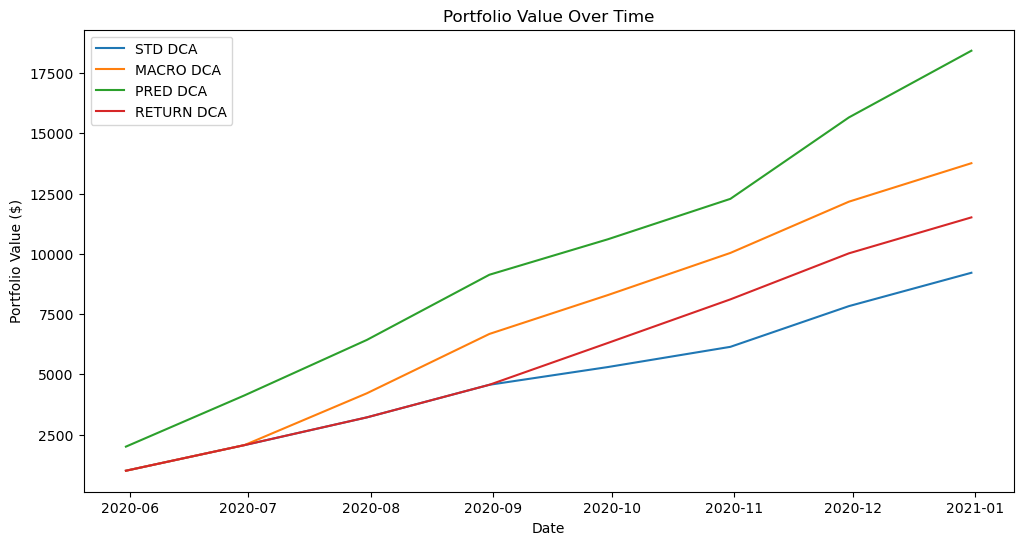

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define fixed investment amount for Standard DCA
investment_amount = 1000

# Calculate CPI_change and past returns for the entire dataset
raw_data['CPI_change'] = raw_data['CPI_Actual'].pct_change()
raw_data['return'] = raw_data['close'].pct_change()

# Subset to the last 8 rows
last_8_data = raw_data.iloc[-8:].copy()

# Set 'date' as index if present
if 'date' in last_8_data.columns:
    last_8_data.set_index('date', inplace=True)

# --- Standard DCA ---
last_8_data['investment_std_dca'] = investment_amount
last_8_data['shares_purchased_std_dca'] = last_8_data['investment_std_dca'] / last_8_data['close']
last_8_data['total_shares_std_dca'] = last_8_data['shares_purchased_std_dca'].cumsum()
last_8_data['total_investment_std_dca'] = last_8_data['investment_std_dca'].cumsum()
last_8_data['portfolio_value_std_dca'] = last_8_data['total_shares_std_dca'] * last_8_data['close']

# --- Macro DCA ---
last_8_data['investment_macro_dca'] = np.where(last_8_data['CPI_change'] > 0, 2000, 1000)
last_8_data['shares_purchased_macro_dca'] = last_8_data['investment_macro_dca'] / last_8_data['close']
last_8_data['total_shares_macro_dca'] = last_8_data['shares_purchased_macro_dca'].cumsum()
last_8_data['total_investment_macro_dca'] = last_8_data['investment_macro_dca'].cumsum()
last_8_data['portfolio_value_macro_dca'] = last_8_data['total_shares_macro_dca'] * last_8_data['close']

# --- Prediction-Based DCA ---
# Assumes 'future_log_return' is already assigned to the last 8 rows
last_8_data['investment_pred_dca'] = np.where(last_8_data['future_log_return'] > 0, 2000, 1000)
last_8_data['shares_purchased_pred_dca'] = last_8_data['investment_pred_dca'] / last_8_data['close']
last_8_data['total_shares_pred_dca'] = last_8_data['shares_purchased_pred_dca'].cumsum()
last_8_data['total_investment_pred_dca'] = last_8_data['investment_pred_dca'].cumsum()
last_8_data['portfolio_value_pred_dca'] = last_8_data['total_shares_pred_dca'] * last_8_data['close']

# --- Return-Based DCA ---
last_8_data['investment_return_dca'] = np.where(last_8_data['return'] < 0, 2000, 1000)
last_8_data['shares_purchased_return_dca'] = last_8_data['investment_return_dca'] / last_8_data['close']
last_8_data['total_shares_return_dca'] = last_8_data['shares_purchased_return_dca'].cumsum()
last_8_data['total_investment_return_dca'] = last_8_data['investment_return_dca'].cumsum()
last_8_data['portfolio_value_return_dca'] = last_8_data['total_shares_return_dca'] * last_8_data['close']

# --- Calculate Periodic Returns for Each Strategy ---
for strat in ['std_dca', 'macro_dca', 'pred_dca', 'return_dca']:
    last_8_data[f'returns_{strat}'] = last_8_data[f'portfolio_value_{strat}'].pct_change()

# --- Define Functions for Metrics ---
def total_return(final_value, total_investment):
    return (final_value - total_investment) / total_investment * 100

def annualized_return(total_return, num_periods, periods_per_year=8):
    if num_periods < 1:
        return 0
    return (1 + total_return / 100) ** (periods_per_year / num_periods) - 1

def sharpe_ratio(returns, risk_free_rate=0, periods_per_year=8):
    excess_returns = returns - risk_free_rate / periods_per_year
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(periods_per_year)

def volatility(returns):
    return returns.std()

# --- Calculate Metrics for Each Strategy ---
metrics = {}
for strat in ['std_dca', 'macro_dca', 'pred_dca', 'return_dca']:
    final_value = last_8_data[f'portfolio_value_{strat}'].iloc[-1]
    total_investment = last_8_data[f'total_investment_{strat}'].iloc[-1]
    returns = last_8_data[f'returns_{strat}'].dropna()
    
    metrics[strat] = {
        'Total Return (%)': total_return(final_value, total_investment),
        'Annualized Return (%)': annualized_return(
            total_return(final_value, total_investment), len(last_8_data)
        ) * 100,
        'Sharpe Ratio': sharpe_ratio(returns),
        'Volatility (%)': volatility(returns) * 100
    }

# --- Display Metrics ---
print("Backtest Metrics for Each Strategy (Last 8 Periods):")
for strat, strat_metrics in metrics.items():
    print(f"\n{strat.upper().replace('_', ' ')}")
    for metric, value in strat_metrics.items():
        print(f"{metric}: {value:.2f}")

# --- Plot Portfolio Value Over Time ---
plt.figure(figsize=(12, 6))
for strat in ['std_dca', 'macro_dca', 'pred_dca', 'return_dca']:
    plt.plot(last_8_data.index, last_8_data[f'portfolio_value_{strat}'], label=strat.upper().replace('_', ' '))
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()
plt.close()

In [229]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming raw_data is already loaded
# # Example: raw_data = pd.read_csv('your_data.csv')

# # List of indicators
# indicators = [
#     '^VIX', 'BZ=F', 'XLK', 'BTC-USD', 'IXN', 'VXUS', '^TNX', 'DX-Y.NYB', 
#     '^GSPC', '^VXN', '000001.SS', '^STOXX50E', '^N225', '^GDAXI', 
#     '^GSPTSE', '^MXX', '^FTSE', '^FCHI', '^HSI', '^BSESN', '^AXJO', 
#     '^KS11', '^BVSP'
# ]

# # Check if all required columns are present
# required_cols = ['close'] + indicators
# missing_cols = [col for col in required_cols if col not in raw_data.columns]
# if missing_cols:
#     raise ValueError(f"Missing columns in dataset: {missing_cols}")

# # Calculate correlations with 'close'
# close_corr = raw_data[indicators].corrwith(raw_data['close'])

# # Sort correlations in ascending order
# close_corr_sorted = close_corr.sort_values()

# # Print sorted correlations
# print("Correlations with 'close' (sorted ascending):")
# for indicator, corr in close_corr_sorted.items():
#     print(f"{indicator}: {corr:.4f}")

# # Create a bar plot for visualization
# plt.figure(figsize=(10, 12))
# colors = ['red' if val < 0 else 'blue' for val in close_corr_sorted]
# plt.barh(close_corr_sorted.index, close_corr_sorted, color=colors)
# plt.axvline(0, color='black', linewidth=0.8)
# plt.xlabel('Correlation with Close')
# plt.title('Correlation of Indicators with Close Price')
# plt.grid(axis='x')
# plt.tight_layout()
# plt.show()
# plt.close()

# import pandas as pd
# import numpy as np

# # Define fixed investment amount for Standard DCA
# investment_amount = 1000

# # Calculate CPI_change for the entire dataset
# raw_data['CPI_change'] = raw_data['CPI_Actual'].pct_change()

# # Calculate past returns for the entire dataset
# raw_data['return'] = raw_data['close'].pct_change()

# # Subset to the last 8 rows
# last_8_data = raw_data.iloc[-8:].copy()

# # --- Standard DCA ---
# last_8_data['investment_std_dca'] = investment_amount
# last_8_data['shares_purchased_std_dca'] = last_8_data['investment_std_dca'] / last_8_data['close']
# last_8_data['total_shares_std_dca'] = last_8_data['shares_purchased_std_dca'].cumsum()
# last_8_data['total_investment_std_dca'] = last_8_data['investment_std_dca'].cumsum()
# last_8_data['portfolio_value_std_dca'] = last_8_data['total_shares_std_dca'] * last_8_data['close']

# # --- Macro DCA ---
# # Split investment between close and ^TNX when CPI_change < 0
# condition_macro = last_8_data['CPI_change'] < 0
# last_8_data['investment_macro_dca_close'] = np.where(condition_macro, 500, 1000)
# last_8_data['investment_macro_dca_tnx'] = np.where(condition_macro, 500, 0)

# last_8_data['shares_purchased_macro_dca_close'] = last_8_data['investment_macro_dca_close'] / last_8_data['close']
# last_8_data['shares_purchased_macro_dca_tnx'] = last_8_data['investment_macro_dca_tnx'] / last_8_data['^TNX']

# last_8_data['total_shares_macro_dca_close'] = last_8_data['shares_purchased_macro_dca_close'].cumsum()
# last_8_data['total_shares_macro_dca_tnx'] = last_8_data['shares_purchased_macro_dca_tnx'].cumsum()

# last_8_data['total_investment_macro_dca'] = (
#     last_8_data['investment_macro_dca_close'] + 
#     last_8_data['investment_macro_dca_tnx']
# ).cumsum()

# last_8_data['portfolio_value_macro_dca'] = (
#     last_8_data['total_shares_macro_dca_close'] * last_8_data['close'] + 
#     last_8_data['total_shares_macro_dca_tnx'] * last_8_data['^TNX']
# )

# # --- Prediction-Based DCA ---
# # Split investment between close and ^TNX when future_log_return <= 0
# condition_pred = last_8_data['future_log_return'] <= 0
# last_8_data['investment_pred_dca_close'] = np.where(condition_pred, 500, 1000)
# last_8_data['investment_pred_dca_tnx'] = np.where(condition_pred, 500, 0)

# last_8_data['shares_purchased_pred_dca_close'] = last_8_data['investment_pred_dca_close'] / last_8_data['close']
# last_8_data['shares_purchased_pred_dca_tnx'] = last_8_data['investment_pred_dca_tnx'] / last_8_data['^TNX']

# last_8_data['total_shares_pred_dca_close'] = last_8_data['shares_purchased_pred_dca_close'].cumsum()
# last_8_data['total_shares_pred_dca_tnx'] = last_8_data['shares_purchased_pred_dca_tnx'].cumsum()

# last_8_data['total_investment_pred_dca'] = (
#     last_8_data['investment_pred_dca_close'] + 
#     last_8_data['investment_pred_dca_tnx']
# ).cumsum()

# last_8_data['portfolio_value_pred_dca'] = (
#     last_8_data['total_shares_pred_dca_close'] * last_8_data['close'] + 
#     last_8_data['total_shares_pred_dca_tnx'] * last_8_data['^TNX']
# )

# # --- Return-Based DCA ---
# # Split investment between close and ^TNX when return < 0
# condition_return = last_8_data['return'] < 0
# last_8_data['investment_return_dca_close'] = np.where(condition_return, 500, 1000)
# last_8_data['investment_return_dca_tnx'] = np.where(condition_return, 500, 0)

# last_8_data['shares_purchased_return_dca_close'] = last_8_data['investment_return_dca_close'] / last_8_data['close']
# last_8_data['shares_purchased_return_dca_tnx'] = last_8_data['investment_return_dca_tnx'] / last_8_data['^TNX']

# last_8_data['total_shares_return_dca_close'] = last_8_data['shares_purchased_return_dca_close'].cumsum()
# last_8_data['total_shares_return_dca_tnx'] = last_8_data['shares_purchased_return_dca_tnx'].cumsum()

# last_8_data['total_investment_return_dca'] = (
#     last_8_data['investment_return_dca_close'] + 
#     last_8_data['investment_return_dca_tnx']
# ).cumsum()

# last_8_data['portfolio_value_return_dca'] = (
#     last_8_data['total_shares_return_dca_close'] * last_8_data['close'] + 
#     last_8_data['total_shares_return_dca_tnx'] * last_8_data['^TNX']
# )

# # --- Extract Final Results ---
# final_row = last_8_data.iloc[-1]

# # Standard DCA Metrics
# avg_cost_std_dca = final_row['total_investment_std_dca'] / final_row['total_shares_std_dca']
# gain_std_dca = final_row['portfolio_value_std_dca'] - final_row['total_investment_std_dca']

# # Macro DCA Metrics
# total_shares_macro = final_row['total_shares_macro_dca_close'] + final_row['total_shares_macro_dca_tnx']
# avg_cost_macro_dca = final_row['total_investment_macro_dca'] / total_shares_macro if total_shares_macro != 0 else 0
# gain_macro_dca = final_row['portfolio_value_macro_dca'] - final_row['total_investment_macro_dca']

# # Prediction-Based DCA Metrics
# total_shares_pred = final_row['total_shares_pred_dca_close'] + final_row['total_shares_pred_dca_tnx']
# avg_cost_pred_dca = final_row['total_investment_pred_dca'] / total_shares_pred if total_shares_pred != 0 else 0
# gain_pred_dca = final_row['portfolio_value_pred_dca'] - final_row['total_investment_pred_dca']

# # Return-Based DCA Metrics
# total_shares_return = final_row['total_shares_return_dca_close'] + final_row['total_shares_return_dca_tnx']
# avg_cost_return_dca = final_row['total_investment_return_dca'] / total_shares_return if total_shares_return != 0 else 0
# gain_return_dca = final_row['portfolio_value_return_dca'] - final_row['total_investment_return_dca']

# # Display Results
# print("Standard DCA (Last 8 Periods):")
# print(f"Average Cost per Share: ${avg_cost_std_dca:.2f}")
# print(f"Unrealized Gain: ${gain_std_dca:.2f}")

# print("\nMacro DCA (Last 8 Periods):")
# print(f"Average Cost per Share: ${avg_cost_macro_dca:.2f}")
# print(f"Unrealized Gain: ${gain_macro_dca:.2f}")

# print("\nPrediction-Based DCA (Last 8 Periods):")
# print(f"Average Cost per Share: ${avg_cost_pred_dca:.2f}")
# print(f"Unrealized Gain: ${gain_pred_dca:.2f}")

# print("\nReturn-Based DCA (Last 8 Periods):")
# print(f"Average Cost per Share: ${avg_cost_return_dca:.2f}")
# print(f"Unrealized Gain: ${gain_return_dca:.2f}")

In [137]:
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.feature_selection import RFECV
# from sklearn.ensemble import RandomForestRegressor
# from torch.utils.data import DataLoader, TensorDataset
# import matplotlib.pyplot as plt
# import itertools
# from scipy.stats import norm

# # Step 1: Load Data
# def load_stock_data(file_path, start_date, end_date):
#     """Load stock data from SQLite database using StockFeaturePipeline."""
#     pipeline = StockFeaturePipeline(file_path)
#     data = pipeline.run_pipeline(start_date, end_date)
#     return data

# # Step 2: Handle Missing Values
# def handle_missing_values(df):
#     """Remove rows with missing target and fill NaNs in numerical columns with means."""
#     df = df.dropna(subset=['Future_Log_Returns'])  # Drop rows where target is NaN
#     numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Future_Log_Returns', errors='ignore')
#     for col in numerical_cols:
#         df[col] = df[col].fillna(df[col].mean())
#     return df

# # Step 3: Detect and Handle Outliers
# def z_score_mark_outliers(df, threshold=3, handle_outliers=True):
#     """Detect and cap outliers using z-scores."""
#     df = df.copy()
#     numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
#     if not numerical_cols.size:
#         print("No numerical columns found.")
#         return df
    
#     total_outliers = 0
#     for col in numerical_cols:
#         mean = df[col].mean()
#         std = df[col].std()
#         if std == 0:
#             continue
#         z_scores = np.abs((df[col] - mean) / std)
#         col_outliers = z_scores > threshold
#         total_outliers += col_outliers.sum()
#         if handle_outliers:
#             lower_bound = mean - threshold * std
#             upper_bound = mean + threshold * std
#             df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
#     prob = 100 * 2 * norm.sf(threshold)
#     print(f"z-score threshold {threshold}: {prob:.2f}% probability, {total_outliers} outliers handled.")
#     return df

# # Step 4: Apply Log Transformation
# def log_transform_df(df):
#     """Apply log transformation to numerical columns, handling non-positive values."""
#     df = df.copy()
#     numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
#     if not numerical_cols.size:
#         print("No numerical columns found.")
#         return df
    
#     for col in numerical_cols:
#         min_value = df[col].min()
#         constant = abs(min_value) + 1 if min_value <= 0 else 1
#         df[col] = np.log(df[col] + constant)
#     return df

# # Step 5: Scale Data
# def min_max_scaler_all_numerical(df, feature_range=(0, 1)):
#     """Scale all numerical columns using Min-Max scaling."""
#     df = df.copy()
#     numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
#     if not numerical_cols.size:
#         print("No numerical columns found.")
#         return df
    
#     for col in numerical_cols:
#         if df[col].isna().all() or df[col].nunique() <= 1:
#             print(f"Skipping {col}: NaN or constant.")
#             continue
#         col_min, col_max = df[col].min(), df[col].max()
#         if col_max == col_min:
#             continue
#         df[col] = (df[col] - col_min) / (col_max - col_min) * (feature_range[1] - feature_range[0]) + feature_range[0]
#     return df

# # Step 6: Prepare Sequences
# def prepare_sequences(df, seq_len=10, test_size=0.2):
#     """Convert DataFrame into sequences for time series modeling."""
#     for col in df.columns:
#         if pd.api.types.is_period_dtype(df[col]):
#             df[col] = df[col].apply(lambda x: x.to_timestamp().toordinal() if pd.notnull(x) else np.nan)
    
#     numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('Future_Log_Returns', errors='ignore')
#     for col in numerical_cols:
#         q1, q3 = df[col].quantile([0.25, 0.75])
#         iqr = q3 - q1
#         df[col] = df[col].clip(q1 - 1.5 * iqr, q3 + 1.5 * iqr)
#     df[numerical_cols] = df[numerical_cols].fillna(method='ffill').fillna(0)
    
#     X_seq, y_seq = [], []
#     for i in range(seq_len, len(df)):
#         X_seq.append(df.iloc[i-seq_len:i][numerical_cols].values)
#         y_seq.append(df.iloc[i]['Future_Log_Returns'])
#     X_seq, y_seq = np.array(X_seq, dtype=float), np.array(y_seq, dtype=float)
    
#     if not np.all(np.isfinite(X_seq)) or not np.all(np.isfinite(y_seq)):
#         raise ValueError("Data contains NaN or infinite values")
    
#     train_size = int((1 - test_size) * len(X_seq))
#     X_train, y_train = X_seq[:train_size], y_seq[:train_size]
#     X_test, y_test = X_seq[train_size:], y_seq[train_size:]
#     return X_train, y_train, X_test, y_test, numerical_cols

# # Step 7: Select Features
# def select_features(X_train, y_train, X_test, numerical_cols, n_features=50):
#     """Select top features using RFECV."""
#     X_train_last = X_train[:, -1, :]
#     estimator = RandomForestRegressor(n_estimators=100, random_state=42)
#     rfecv = RFECV(estimator, step=1, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
#     rfecv.fit(X_train_last, y_train)
    
#     selected_mask = rfecv.support_
#     selected_features = numerical_cols[selected_mask]
#     importances = rfecv.estimator_.feature_importances_
#     feature_df = pd.DataFrame({'feature': selected_features, 'importance': importances}).sort_values('importance', ascending=False)
#     top_features = feature_df.head(n_features)['feature'].tolist()
#     selected_indices = [list(numerical_cols).index(f) for f in top_features]
    
#     print(f"Selected {len(selected_indices)} features:")
#     print(feature_df.head(n_features))
#     return X_train[:, :, selected_indices], X_test[:, :, selected_indices], selected_indices

# # Step 8: Define Models
# class VanillaLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.dropout = nn.Dropout(dropout)
    
#     def forward(self, x):
#         _, (h_n, _) = self.lstm(x)
#         x = self.dropout(h_n[-1])
#         return self.fc(x)

# class BidirectionalLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_size * 2, output_size)
#         self.dropout = nn.Dropout(dropout)
    
#     def forward(self, x):
#         _, (h_n, _) = self.lstm(x)
#         h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)
#         x = self.dropout(h_n)
#         return self.fc(x)

# class CNNLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
#         super().__init__()
#         self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
#         self.lstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.dropout = nn.Dropout(dropout)
    
#     def forward(self, x):
#         x = x.permute(0, 2, 1)
#         x = torch.relu(self.conv1(x))
#         x = self.dropout(x)
#         x = torch.relu(self.conv2(x))
#         x = self.dropout(x)
#         x = x.permute(0, 2, 1)
#         _, (h_n, _) = self.lstm(x)
#         x = self.dropout(h_n[-1])
#         return self.fc(x)

# # Step 9: Train Model
# def train_model(model, train_loader, X_test_tensor, y_test, epochs=50, patience=5, lr=0.0005):
#     """Train a PyTorch model with early stopping."""
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
#     best_loss = float('inf')
#     trigger = 0
    
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for X_batch, y_batch in train_loader:
#             optimizer.zero_grad()
#             outputs = model(X_batch)
#             loss = criterion(outputs, y_batch)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         avg_loss = running_loss / len(train_loader)
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
#         model.eval()
#         with torch.no_grad():
#             y_pred = model(X_test_tensor).numpy().flatten()
#             val_loss = mean_squared_error(y_test, y_pred)
#             if val_loss < best_loss:
#                 best_loss = val_loss
#                 trigger = 0
#             else:
#                 trigger += 1
#                 if trigger >= patience:
#                     print("Early stopping triggered")
#                     break
#     return model

# # Step 10: Evaluate Model
# def evaluate_model(model, X_test_tensor, y_test, model_name):
#     """Evaluate model performance and save residual plot."""
#     model.eval()
#     with torch.no_grad():
#         y_pred = model(X_test_tensor).numpy().flatten()
    
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
    
#     print(f"\n{model_name} Performance:")
#     print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    
#     residuals = y_test - y_pred
#     plt.figure(figsize=(10, 6))
#     plt.plot(residuals, label='Residuals')
#     plt.title(f"{model_name} Residuals")
#     plt.xlabel("Test Sample Index")
#     plt.ylabel("Residual Value")
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(f'{model_name.lower().replace(" ", "_")}_residuals.png')
#     plt.close()
    
#     return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# # Step 11: Tune Bidirectional LSTM
# def tune_bidirectional_lstm(X_train_tensor, y_train_tensor, X_test_tensor, y_test, sel_indices):
#     """Perform grid search to tune Bidirectional LSTM hyperparameters."""
#     learning_rates = [0.001, 0.0005, 0.0001]
#     hidden_sizes = [50, 100, 150]
#     num_layers_list = [1, 2, 3]
#     dropout_rates = [0.2, 0.3, 0.4]
#     batch_sizes = [32, 64, 128]
    
#     best_r2 = -float('inf')
#     best_params = {}
#     best_model = None
    
#     param_combinations = list(itertools.product(learning_rates, hidden_sizes, num_layers_list, dropout_rates, batch_sizes))
    
#     for lr, hidden_size, num_layers, dropout, batch_size in param_combinations:
#         print(f"\nTesting: lr={lr}, hidden={hidden_size}, layers={num_layers}, dropout={dropout}, batch={batch_size}")
#         train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        
#         model = BidirectionalLSTM(input_size=len(sel_indices), hidden_size=hidden_size, num_layers=num_layers, output_size=1, dropout=dropout)
#         trained_model = train_model(model, train_loader, X_test_tensor, y_test, epochs=50, patience=5, lr=lr)
#         metrics = evaluate_model(trained_model, X_test_tensor, y_test, f"BiLSTM (lr={lr}, hidden={hidden_size})")
        
#         if metrics['R2'] > best_r2:
#             best_r2 = metrics['R2']
#             best_params = {'lr': lr, 'hidden_size': hidden_size, 'num_layers': num_layers, 'dropout': dropout, 'batch_size': batch_size}
#             best_model = trained_model
    
#     print("\nBest Hyperparameters:", best_params)
#     print(f"Best R²: {best_r2:.4f}")
#     return best_model, best_params

# # Step 12: Main Execution Pipeline
# def main():
#     """Execute the full stock prediction pipeline."""
#     # Load and preprocess data
#     file_path = '/Users/kevinleungch421/Documents/GitHub/Database/DataBase/stock_price.sqlite'
#     raw_data = load_stock_data(file_path, '2017-01-01', '2021-01-01')
#     clean_data = handle_missing_values(raw_data)
#     outlier_data = z_score_mark_outliers(clean_data)
#     transformed_data = log_transform_df(outlier_data)
#     scaled_df = min_max_scaler_all_numerical(transformed_data)
    
#     # Prepare sequences and features
#     X_train, y_train, X_test, y_test, numerical_cols = prepare_sequences(scaled_df)
#     X_train_sel, X_test_sel, sel_indices = select_features(X_train, y_train, X_test, numerical_cols)
    
#     # Convert to tensors
#     X_train_tensor = torch.tensor(X_train_sel, dtype=torch.float32)
#     y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
#     X_test_tensor = torch.tensor(X_test_sel, dtype=torch.float32)
#     train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    
#     # Compare models
#     model_configs = [
#         ('Vanilla LSTM', VanillaLSTM(len(sel_indices), 100, 2, 1)),
#         ('Bidirectional LSTM', BidirectionalLSTM(len(sel_indices), 100, 2, 1)),
#         ('CNN-LSTM', CNNLSTM(len(sel_indices), 100, 2, 1))
#     ]
    
#     results = {}
#     for name, model in model_configs:
#         print(f"\nTraining {name}...")
#         trained_model = train_model(model, train_loader, X_test_tensor, y_test)
#         results[name] = evaluate_model(trained_model, X_test_tensor, y_test, name)
    
#     print("\nModel Comparison Summary:")
#     for name, metrics in results.items():
#         print(f"{name}: MSE={metrics['MSE']:.4f}, RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}, R²={metrics['R2']:.4f}")
    
#     # Optimize Bidirectional LSTM
#     best_model, best_params = tune_bidirectional_lstm(X_train_tensor, y_train_tensor, X_test_tensor, y_test, sel_indices)
#     final_metrics = evaluate_model(best_model, X_test_tensor, y_test, "Best Bidirectional LSTM")
#     print("\nFinal Model Performance:")
#     for key, value in final_metrics.items():
#         print(f"{key}: {value:.4f}")

# if __name__ == "__main__":
#     main()

In [ ]:
# import torch.nn as nn

# class BidirectionalLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0, activation=None):
#         super(BidirectionalLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
#         self.dropout = nn.Dropout(dropout)
#         self.fc = nn.Linear(hidden_size * 2, output_size)
#         # Set activation function (default to None for linear output)
#         self.activation = activation if activation is not None else nn.Identity()

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.dropout(out[:, -1, :])
#         out = self.fc(out)
#         out = self.activation(out)  # Apply the activation function
#         return out

# from torch.utils.data import DataLoader, TensorDataset
# import itertools

# def tune_bidirectional_lstm(X_train_tensor, y_train_tensor, X_test_tensor, y_test, sel_indices):
#     """Perform grid search to tune Bidirectional LSTM hyperparameters, including activation functions."""
#     learning_rates = [0.001, 0.0005, 0.0001]
#     hidden_sizes = [50, 100, 150]
#     num_layers_list = [1, 2, 3]
#     dropout_rates = [0.2, 0.3, 0.4]
#     batch_sizes = [32, 64, 128]
#     activations = [None, nn.Tanh(), nn.ReLU()]  # List of activation functions to test

#     best_r2 = -float('inf')
#     best_params = {}
#     best_model = None

#     # Include activations in the parameter combinations
#     param_combinations = list(itertools.product(learning_rates, hidden_sizes, num_layers_list, dropout_rates, batch_sizes, activations))

#     for lr, hidden_size, num_layers, dropout, batch_size, activation in param_combinations:
#         print(f"\nTesting: lr={lr}, hidden={hidden_size}, layers={num_layers}, dropout={dropout}, batch={batch_size}, activation={activation}")
#         train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

#         # Initialize the model with the activation function
#         model = BidirectionalLSTM(input_size=len(sel_indices), hidden_size=hidden_size, num_layers=num_layers, output_size=1, dropout=dropout, activation=activation)
#         trained_model = train_model(model, train_loader, X_test_tensor, y_test, epochs=50, patience=5, lr=lr)
#         metrics = evaluate_model(trained_model, X_test_tensor, y_test, f"BiLSTM (lr={lr}, hidden={hidden_size}, activation={activation})")

#         if metrics['R2'] > best_r2:
#             best_r2 = metrics['R2']
#             best_params = {
#                 'lr': lr,
#                 'hidden_size': hidden_size,
#                 'num_layers': num_layers,
#                 'dropout': dropout,
#                 'batch_size': batch_size,
#                 'activation': activation
#             }
#             best_model = trained_model

#     print("\nBest Hyperparameters:", best_params)
#     print(f"Best R²: {best_r2:.4f}")
#     return best_model, best_params

# # Run the tuning function
# best_model, best_params = tune_bidirectional_lstm(X_train_tensor, y_train_tensor, X_test_tensor, y_test, sel_indices)
# final_metrics = evaluate_model(best_model, X_test_tensor, y_test, "Best Bidirectional LSTM")
# print("\nFinal Model Performance:")
# for key, value in final_metrics.items():
#     print(f"{key}: {value:.4f}")